In [137]:
pip install pmdarima

     |████████████████████████████████| 656 kB 3.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [339]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

# Load Data

In [283]:
east = pd.read_csv('data/east_daily.csv')
midwest = pd.read_csv('data/midwest_daily.csv') 
south = pd.read_csv('data/south_daily.csv') 
west = pd.read_csv('data/west_daily.csv') 

# Check Stationarity

In [284]:
X = east.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.842138
p-value: 0.002504
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [285]:
X = midwest.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.473716
p-value: 0.122001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [286]:
X = south.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.104854
p-value: 0.026196
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [287]:
X = west.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.816341
p-value: 0.055977
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Differencing

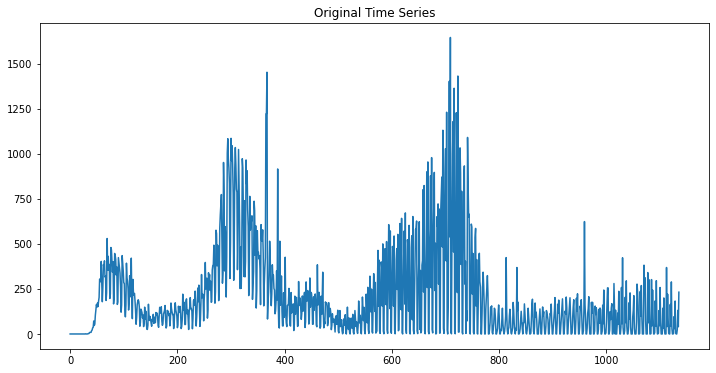

In [288]:
plt.figure(figsize=(12, 6))
plt.plot(midwest['daily_deaths'], label='Original Time Series')
plt.title('Original Time Series')
plt.show()

In [290]:
midwest_stationary = midwest['date'].to_frame().join(midwest['daily_deaths'].diff(1).fillna(0))

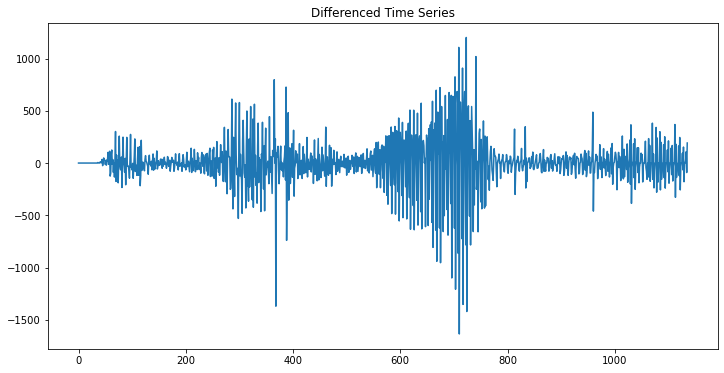

In [291]:
plt.figure(figsize=(12, 6))
plt.plot(midwest_stationary['daily_deaths'], label='Differenced Time Series')
plt.title('Differenced Time Series')
plt.show()

In [292]:
south_stationary = south['date'].to_frame().join(south['daily_deaths'].diff(1).fillna(0))

In [293]:
west_stationary = west['date'].to_frame().join(west['daily_deaths'].diff(1).fillna(0))

# Check Stationarity After Differencing

In [294]:
X = midwest_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.612100
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [295]:
X = south_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.157430
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [296]:
X = west_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.691688
p-value: 0.000001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Create New CSVs

In [297]:
midwest_stationary.to_csv('midwest_stationary.csv', index = False)

In [298]:
south_stationary.to_csv('south_stationary.csv', index = False)

In [299]:
west_stationary.to_csv('west_stationary.csv', index = False)

# Split Data Into Train and Test

In [315]:
east_stationary = pd.read_csv('data/east_daily.csv', index_col=0, parse_dates=[0])
midwest_stationary = pd.read_csv('data/midwest_stationary.csv', index_col=0, parse_dates=[0])
south_stationary = pd.read_csv('data/south_stationary.csv', index_col=0, parse_dates=[0])
west_stationary = pd.read_csv('data/west_stationary.csv', index_col=0, parse_dates=[0])

In [316]:
east_stationary = east_stationary.sort_index()
midwest_stationary = midwest_stationary.sort_index()
south_stationary = south_stationary.sort_index()
west_stationary = west_stationary.sort_index()

In [317]:
train_size = int(len(east_stationary) * 0.9)

east_train, east_test = east_stationary[0:train_size], east_stationary[train_size:]
print(east_train.shape, east_test.shape)

midwest_train, midwest_test = midwest_stationary[0:train_size], midwest_stationary[train_size:]
print(midwest_train.shape, midwest_test.shape)

south_train, south_test = south_stationary[0:train_size], south_stationary[train_size:]
print(south_train.shape, south_test.shape)

west_train, west_test = west_stationary[0:train_size], west_stationary[train_size:]
print(west_train.shape, west_test.shape)

(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)


In [318]:
east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-02-12,NaN,0.0
2020-02-13,NaN,0.0
2020-02-14,NaN,0.0
2020-02-15,NaN,0.0
2020-02-16,NaN,0.0
...,...,...
2023-03-19,0.0,NaN
2023-03-20,37.0,NaN
2023-03-21,-4.0,NaN


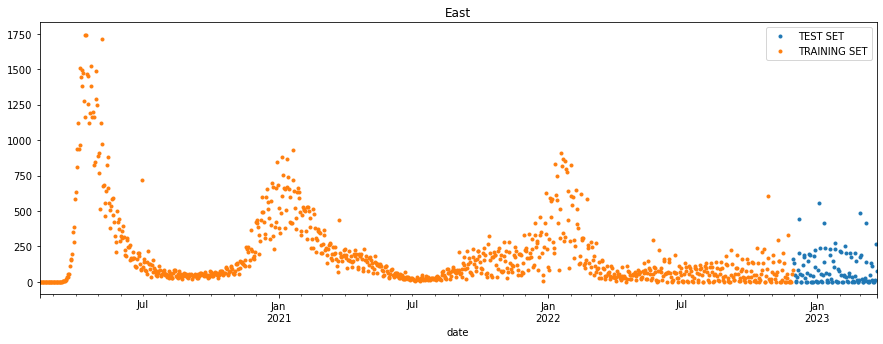

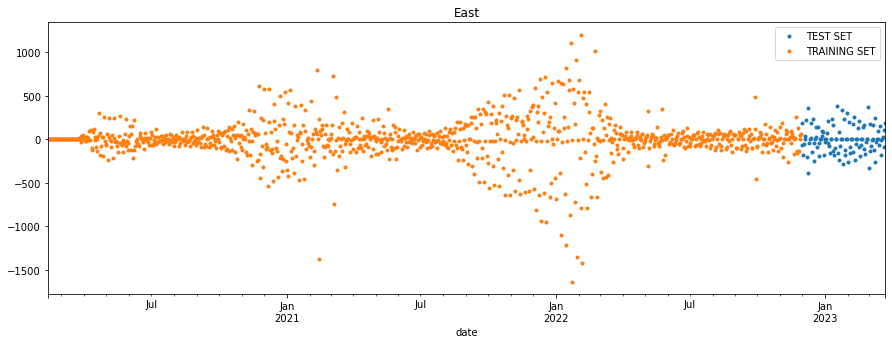

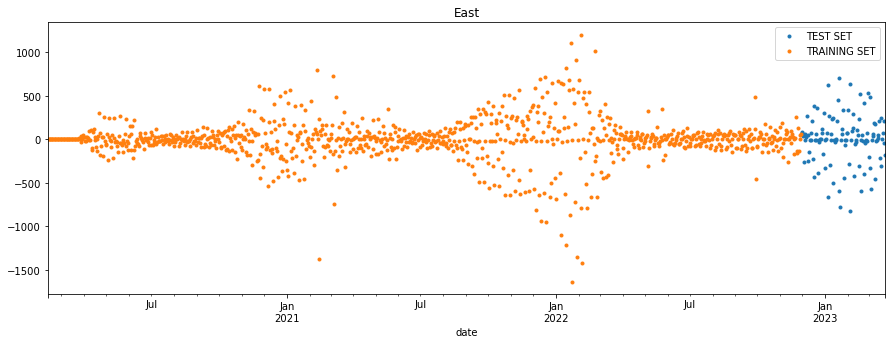

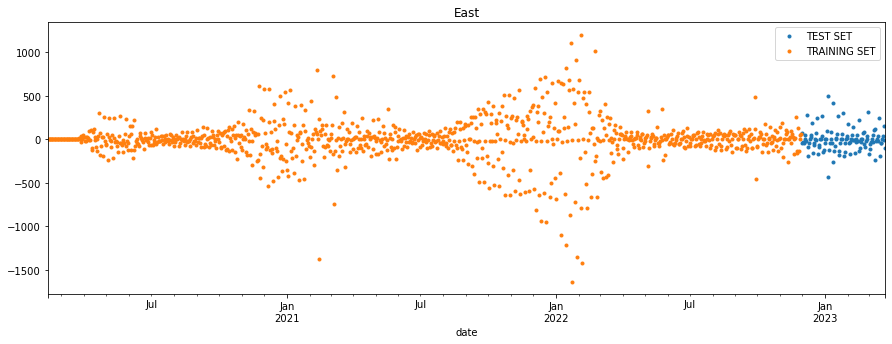

In [319]:
_ = east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

# ACF and PACF

### east

AR(1) model
- ACF tails off
- PACF cut off at lag 1

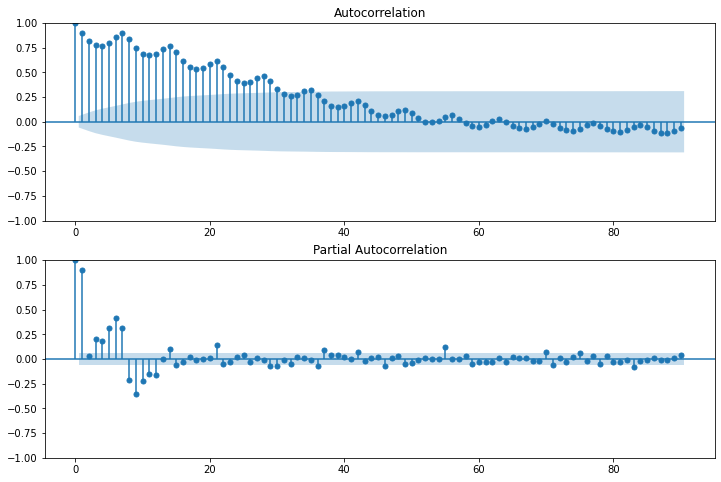

In [328]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(east_stationary,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(east_stationary,lags=90,ax=ax2)

### midwest

MA(1) model
- ACF cut off at lag 1
- PACF tails off

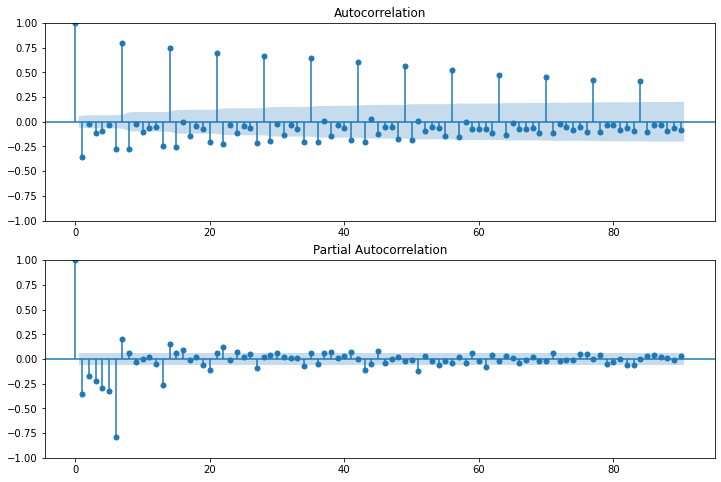

In [329]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(midwest_stationary,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(midwest_stationary,lags=90,ax=ax2)

### south

MA(5) model
- ACF cut off at lag 5
- PACF tails off

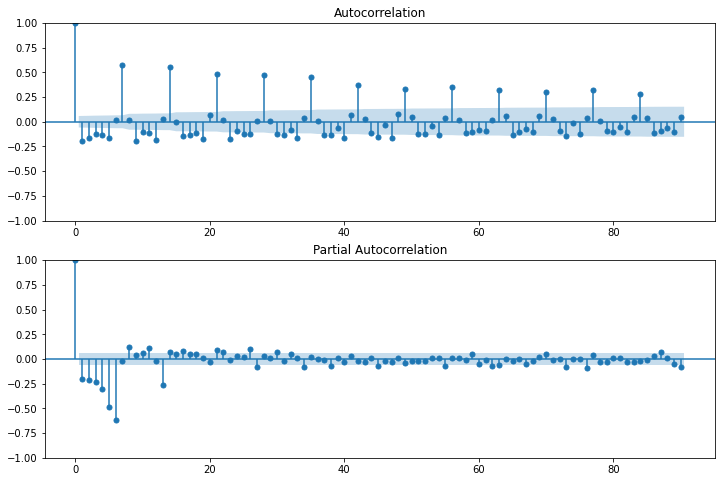

In [330]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(south_stationary,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(south_stationary,lags=90,ax=ax2)

### west

MA(5) model
- ACF cut off at lag 5
- PACF tails off

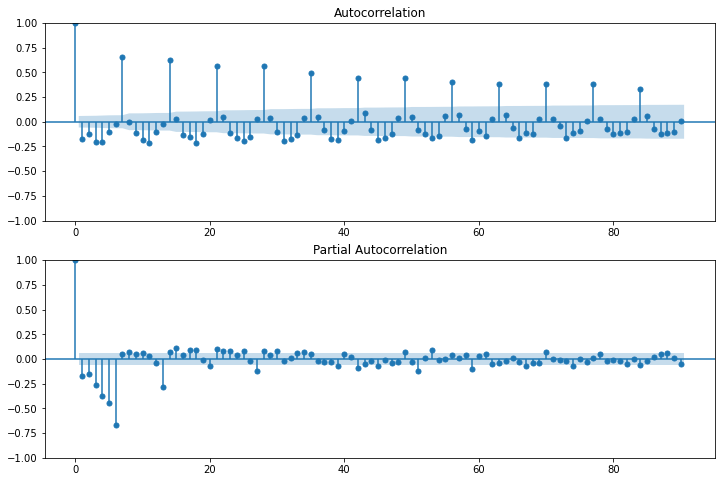

In [331]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(west_stationary,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(west_stationary,lags=90,ax=ax2)

# ARIMA Models (grid search p and q)

In [361]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted.iloc[1:].values - Actual.iloc[:-1].values))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# Grid Search p and q

### east

In [373]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,4,4,12019.444256
18,3,3,12027.195774
19,3,4,12029.635327
22,4,2,12073.746497
23,4,3,12083.189447
14,2,4,12209.989462
13,2,3,12260.905697
9,1,4,12307.445470
21,4,1,12328.592672
16,3,1,12353.494338


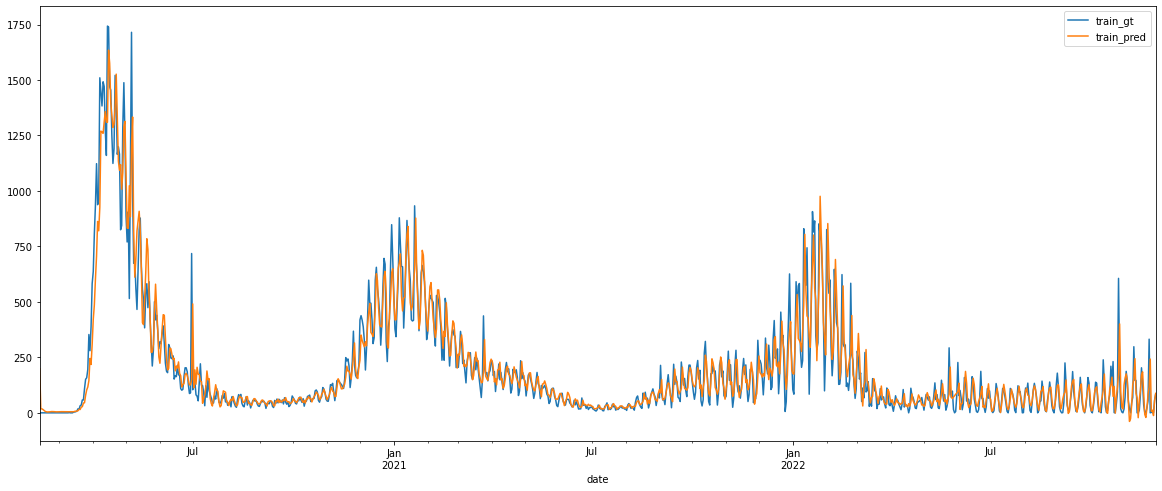

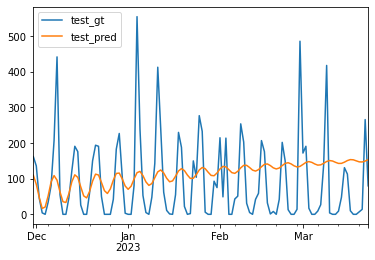

Training Set Metrics:
R-squared: 0.8979603749246248
MAE: 49.03799759212213
MASE: 0.00020735792498815907

Testing Set Metrics:
R-squared: -0.0006393340197585751
MAE: 91.53067439385967
MASE: 0.008151072042021423


In [374]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(4,0,4))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

- seemed to underfit
- increase p and q
- shift down by 100
- filter above zero

In [467]:
results=[]
for p in range(3,7):
    for q in range(3,7):
        model=sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,6,6,11800.445572
11,5,6,11850.802397
14,6,5,11880.336364
10,5,5,11891.908581
6,4,5,11901.431019
2,3,5,11902.678270
9,5,4,11903.549108
3,3,6,11903.933034
7,4,6,11905.450196
13,6,4,11960.565424


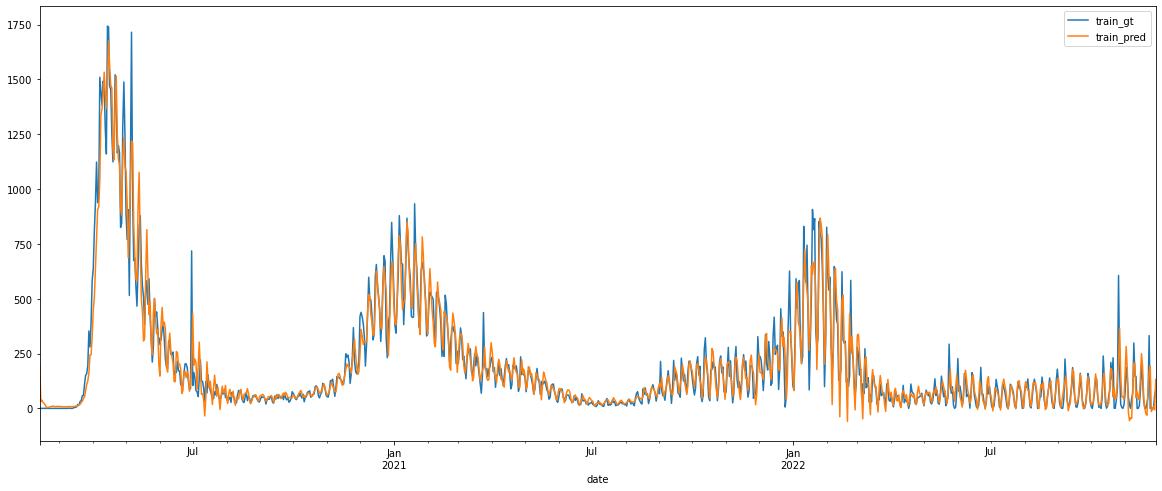

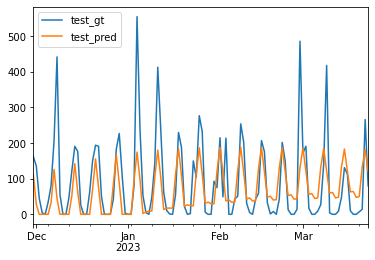

Training Set Metrics:
R-squared: 0.9189785707861602
MAE: 45.673374034029656
MASE: 0.00019174643015355323

Testing Set Metrics:
R-squared: 0.3574782514182264
MAE: 59.725889249924826
MASE: 0.005597274975354982


In [405]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(6,0,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred = test_pred - 100
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

### midwest

In [376]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,4,4,13444.919632
9,1,4,13562.858191
23,4,3,13590.059980
8,1,3,13616.737234
3,0,3,13628.156250
7,1,2,13631.972753
4,0,4,13645.302660
2,0,2,13670.510536
14,2,4,13705.708548
18,3,3,13727.669349


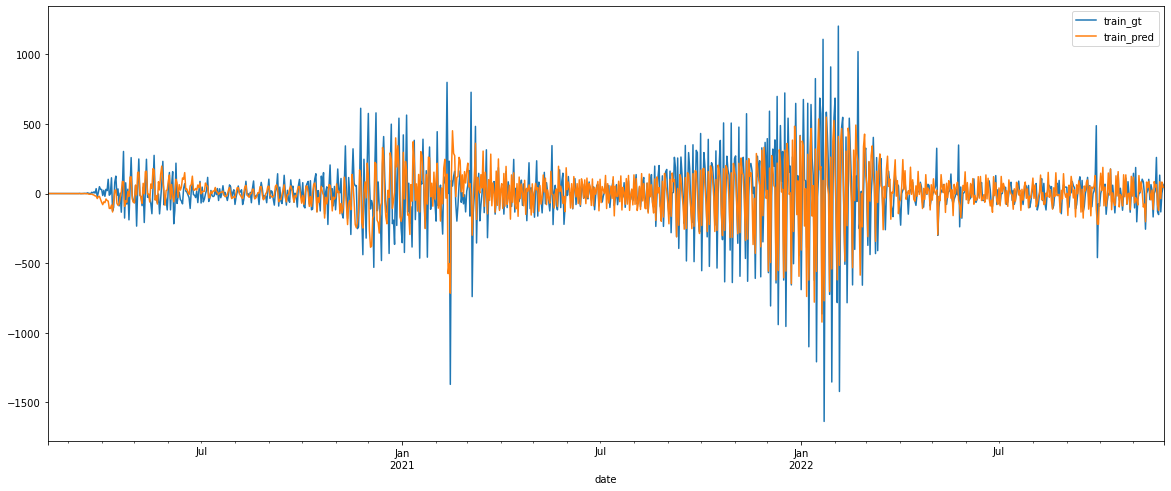

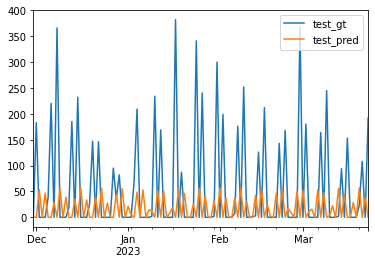

Training Set Metrics:
R-squared: 0.485058270958012
MAE: 114.240633670136
MASE: 0.0005720445762899049

Testing Set Metrics:
R-squared: -0.4060326359968094
MAE: 74.03877504176033
MASE: 0.010290211703132645


In [642]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(4,1,4))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

- increase p and q
- change negative death values to zero for both prediction and test

In [468]:
results=[]
for p in range(3,7):
    for q in range(3,7):
        model=sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,6,6,12658.953850
13,6,4,12661.417033
14,6,5,12661.846462
12,6,3,12667.055664
5,4,4,13444.919632
11,5,6,13577.446045
4,4,3,13590.059980
8,5,3,13590.352952
9,5,4,13616.865293
6,4,5,13645.384797


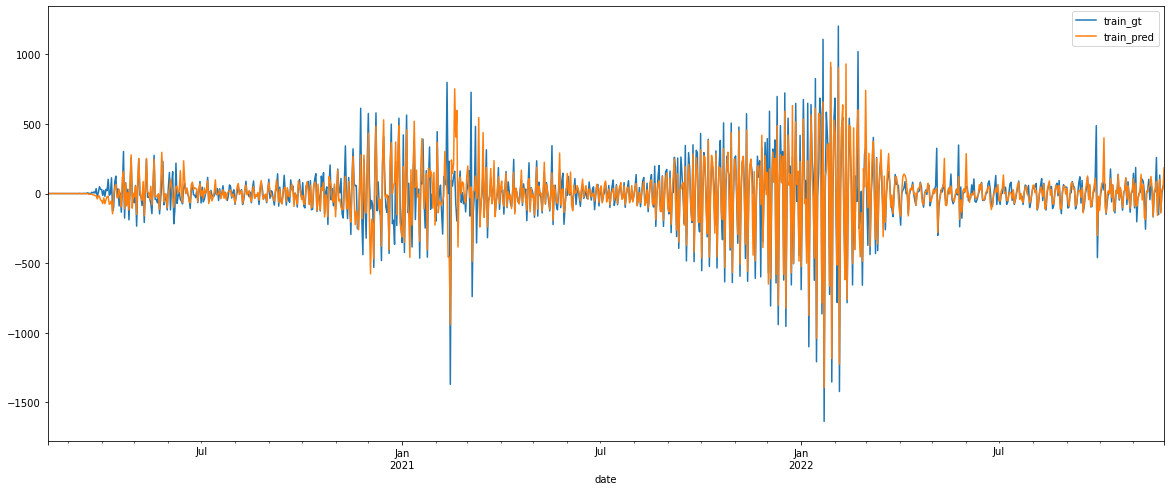

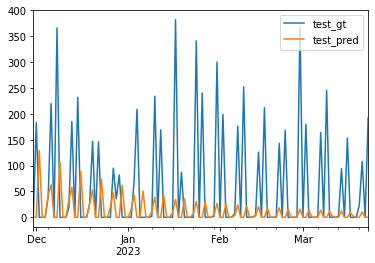

Training Set Metrics:
R-squared: 0.7612377969246924
MAE: 67.80854253435264
MASE: 0.00031748307264801843

Testing Set Metrics:
R-squared: -0.23165837124421218
MAE: 60.0298786400409
MASE: 0.008615278528946592


In [478]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
midwest_test[midwest_test<0]=0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

### south

In [378]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
12,2,2,10.000000
22,4,2,14198.107887
14,2,4,14389.296340
3,0,3,14395.212203
8,1,3,14396.996320
9,1,4,14397.742557
4,0,4,14419.797985
2,0,2,14534.584142
21,4,1,14534.652438
18,3,3,14576.988985


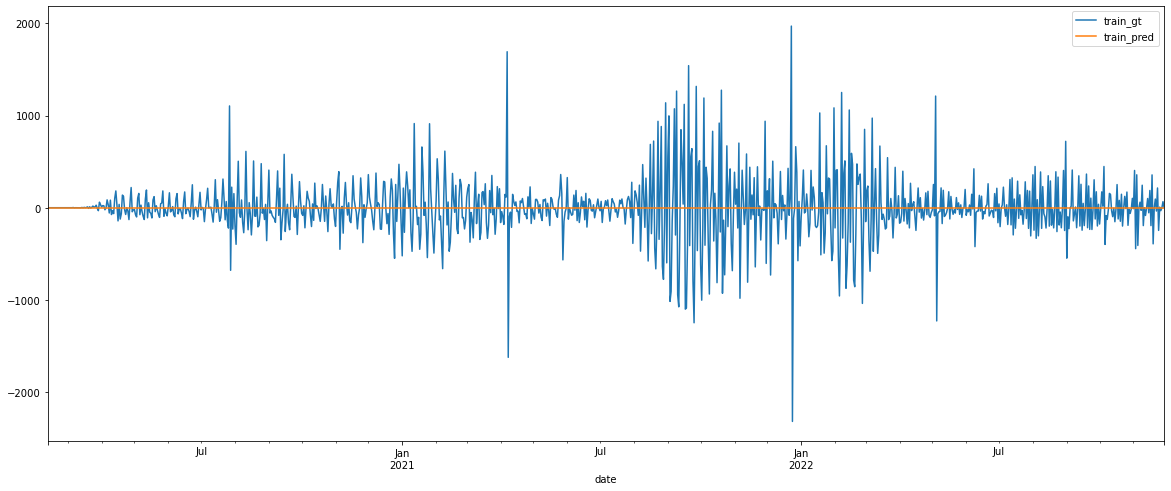

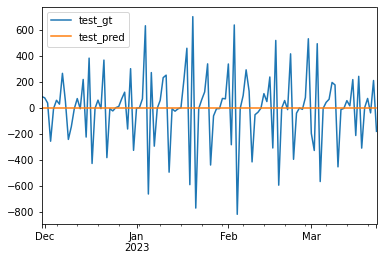

Training Set Metrics:
R-squared: -3.9126975215353355e-08
MAE: 204.48825831702544
MASE: 0.0009784782632187106

Testing Set Metrics:
R-squared: -7.987745886950393e-08
MAE: 192.359649122807
MASE: 0.008845341845900906


In [381]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(2,1,2))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(south_train, train_pred)
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(south_test, test_pred)
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

- increase p and q
- filter above zero
- scale test pred by 1.6

In [479]:
results=[]
for p in range(3,7):
    for q in range(3,7):
        model=sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,6,6,13720.187492
14,6,5,13728.601556
12,6,3,13753.752125
13,6,4,13756.371780
11,5,6,13964.215320
9,5,4,14017.346941
8,5,3,14025.716818
10,5,5,14053.462632
7,4,6,14197.016136
3,3,6,14332.068806


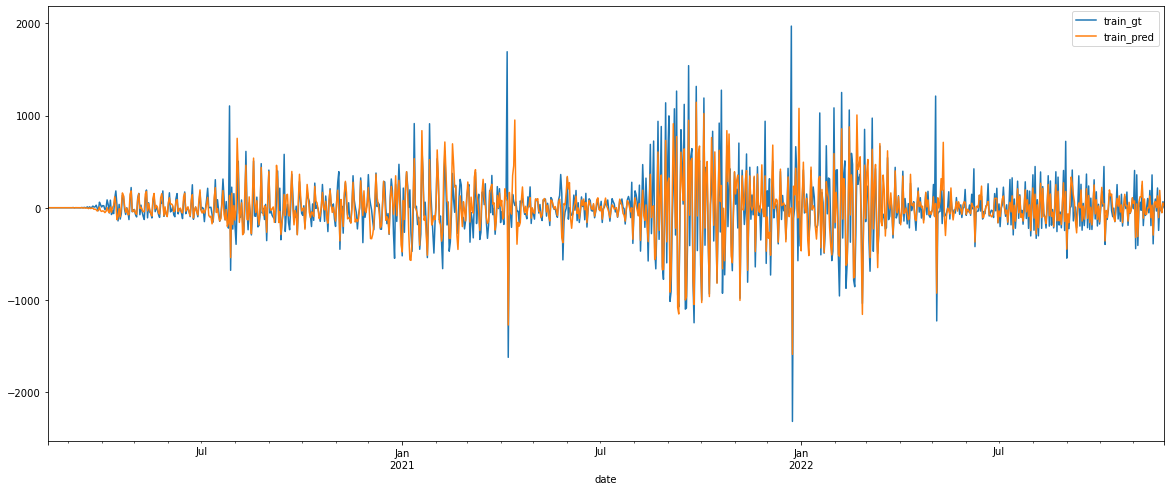

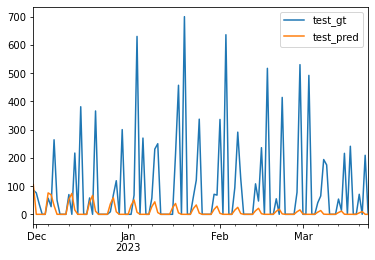

Training Set Metrics:
R-squared: 0.6506617364130307
MAE: 115.10464571379147
MASE: 0.00038322581271183756

Testing Set Metrics:
R-squared: -0.31177252507569353
MAE: 91.63855735343893
MASE: 0.008289090749491973


In [488]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
south_test[south_test<0]=0
test_pred = test_pred * 2


pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(south_train, train_pred)
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(south_test, test_pred)
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

### west

In [382]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,4,4,12644.844427
14,2,4,12861.385542
9,1,4,12881.782656
8,1,3,12882.727930
4,0,4,12906.747923
3,0,3,12915.796785
21,4,1,12962.063667
2,0,2,13028.184706
22,4,2,13029.148524
23,4,3,13042.046987


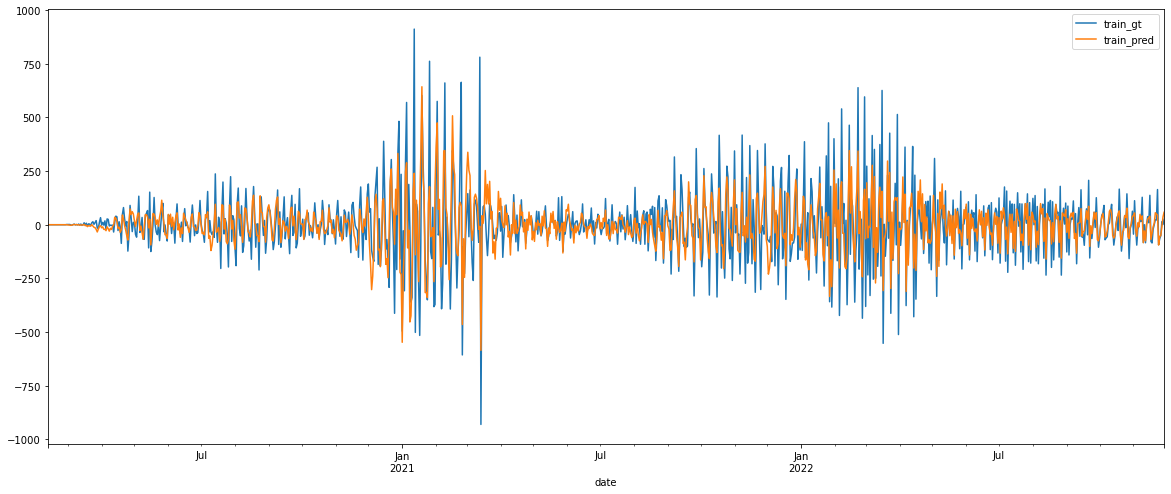

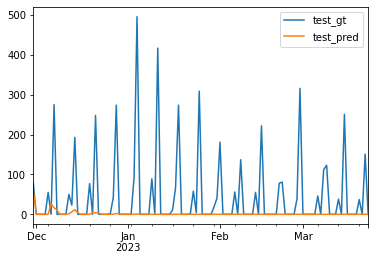

Training Set Metrics:
R-squared: 0.4658337007414375
MAE: 75.93792758927509
MASE: 0.0005540926890058662

Testing Set Metrics:
R-squared: -0.2086735745670445
MAE: 44.44687147088749
MASE: 0.008632409872811385


In [643]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(4,1,4))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

- increase p and q
- filter above zero
- scale test pred

In [459]:
results=[]
for p in range(3,7):
    for q in range(3,7):
        model=sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,6,6,12176.035999
14,6,5,12183.379511
12,6,3,12187.176396
13,6,4,12191.802854
9,5,4,12531.101317
8,5,3,12634.332203
11,5,6,12644.221655
5,4,4,12644.844427
7,4,6,12694.375760
10,5,5,12714.373313


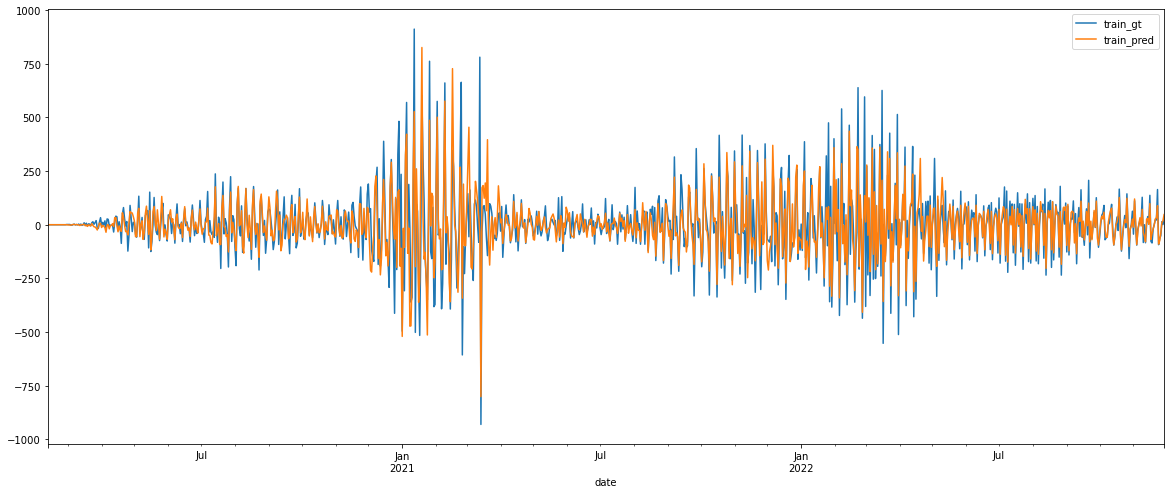

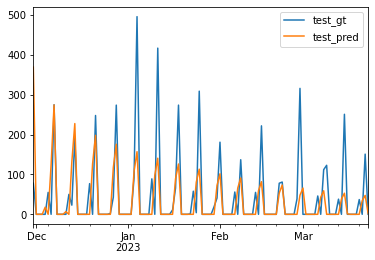

Training Set Metrics:
R-squared: 0.6601899900950967
MAE: 54.80193598206107
MASE: 0.00037632792164732744

Testing Set Metrics:
R-squared: 0.36032483707698715
MAE: 36.16527313702939
MASE: 0.005228979252710879


In [466]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
west_test[west_test<0]=0
test_pred = test_pred * 3
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

# Time Series Decomposition

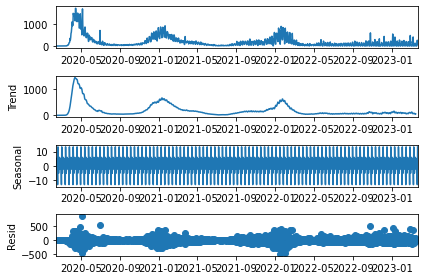

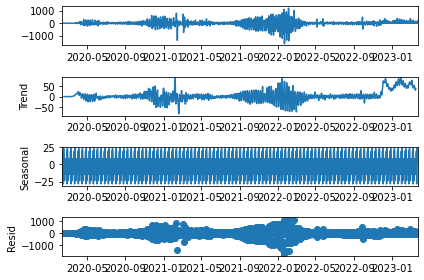

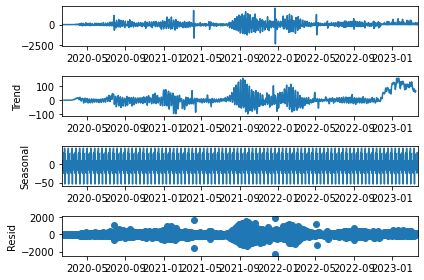

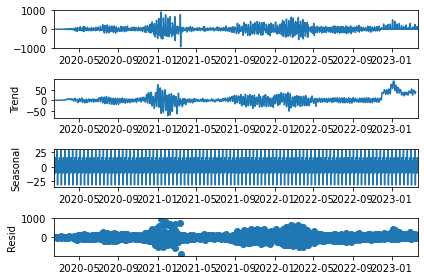

In [648]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(east_stationary, period=12).plot()
plt.show()

seasonal_decompose(midwest_stationary, period=12).plot()
plt.show()

seasonal_decompose(south_stationary, period=12).plot()
plt.show()

seasonal_decompose(west_stationary, period=12).plot()
plt.show()

# Auto ARIMA / SARIMA

### east

In [493]:
import warnings
import statsmodels.api 
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(east_train,order=(p,0,q), seasonal_order=(P,0,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37700D+00    |proj g|=  5.68911D-01

At iterate    5    f=  6.11792D+00    |proj g|=  1.05995D-02


 This problem is unconstrained.



At iterate   10    f=  6.10029D+00    |proj g|=  7.08456D-03

At iterate   15    f=  6.09947D+00    |proj g|=  4.24803D-03

At iterate   20    f=  6.09923D+00    |proj g|=  1.36731D-03

At iterate   25    f=  6.09868D+00    |proj g|=  4.71995D-03

At iterate   30    f=  6.09829D+00    |proj g|=  4.67682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   4.947D-05   6.098D+00
  F =   6.0982934322631435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  6.10738D+00    |proj g|=  1.28182D-02

At iterate   10    f=  6.09655D+00    |proj g|=  7.63254D-02

At iterate   15    f=  6.08142D+00    |proj g|=  1.20575D-02

At iterate   20    f=  6.08102D+00    |proj g|=  1.26267D-02

At iterate   25    f=  6.07999D+00    |proj g|=  7.53625D-04

At iterate   30    f=  6.07976D+00    |proj g|=  4.67736D-03

At iterate   35    f=  6.07814D+00    |proj g|=  5.21546D-03

At iterate   40    f=  6.07812D+00    |proj g|=  5.63377D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     52      1     0     0   9.285D-06   6.078D+00
  F =   6.07812335404

 This problem is unconstrained.



At iterate    5    f=  6.11657D+00    |proj g|=  1.04143D-02

At iterate   10    f=  6.08042D+00    |proj g|=  1.33656D-01

At iterate   15    f=  6.06712D+00    |proj g|=  3.11404D-03

At iterate   20    f=  6.06521D+00    |proj g|=  1.98821D-02

At iterate   25    f=  6.06259D+00    |proj g|=  1.96493D-03

At iterate   30    f=  6.06248D+00    |proj g|=  6.30393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     44      1     0     0   1.911D-05   6.062D+00
  F =   6.0624562321494420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.11852D+00    |proj g|=  3.01038D-02

At iterate   10    f=  6.10174D+00    |proj g|=  1.78488D-02

At iterate   15    f=  6.09916D+00    |proj g|=  2.68312D-02

At iterate   20    f=  6.06138D+00    |proj g|=  9.54803D-02

At iterate   25    f=  6.05257D+00    |proj g|=  1.01034D-02

At iterate   30    f=  6.04373D+00    |proj g|=  1.02814D-01

At iterate   35    f=  6.04018D+00    |proj g|=  2.16391D-01

At iterate   40    f=  6.03348D+00    |proj g|=  9.13129D-01

At iterate   45    f=  6.02721D+00    |proj g|=  1.71982D+00

At iterate   50    f=  6.02628D+00    |proj g|=  1.17677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.03835D+00    |proj g|=  3.13706D-03

At iterate   10    f=  6.03671D+00    |proj g|=  2.19605D-02

At iterate   15    f=  6.03630D+00    |proj g|=  6.41067D-04

At iterate   20    f=  6.03589D+00    |proj g|=  1.54653D-03

At iterate   25    f=  6.03588D+00    |proj g|=  5.49341D-04

At iterate   30    f=  6.03582D+00    |proj g|=  1.26680D-03

At iterate   35    f=  6.03582D+00    |proj g|=  2.08712D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     38      1     0     0   2.087D-05   6.036D+00
  F =   6.0358165672879887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.03745D+00    |proj g|=  4.80376D-03

At iterate   10    f=  6.03289D+00    |proj g|=  6.06335D-02

At iterate   15    f=  6.02616D+00    |proj g|=  1.91102D-03

At iterate   20    f=  6.02610D+00    |proj g|=  5.05886D-03

At iterate   25    f=  6.02530D+00    |proj g|=  7.20245D-03

At iterate   30    f=  6.02522D+00    |proj g|=  1.04170D-04

At iterate   35    f=  6.02522D+00    |proj g|=  5.06222D-04

At iterate   40    f=  6.02515D+00    |proj g|=  3.41017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     50      1     0     0   4.951D-05   6.025D+00
  F =   6.02513497075

 This problem is unconstrained.



At iterate    5    f=  6.03863D+00    |proj g|=  1.36969D-02

At iterate   10    f=  6.02550D+00    |proj g|=  7.76492D-02

At iterate   15    f=  6.02252D+00    |proj g|=  1.31883D-02

At iterate   20    f=  6.02221D+00    |proj g|=  9.62122D-04

At iterate   25    f=  6.02203D+00    |proj g|=  1.09273D-02

At iterate   30    f=  6.02097D+00    |proj g|=  2.00719D-03

At iterate   35    f=  6.02096D+00    |proj g|=  1.96969D-03

At iterate   40    f=  6.02085D+00    |proj g|=  2.26348D-03

At iterate   45    f=  6.02084D+00    |proj g|=  1.43848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     59   

 This problem is unconstrained.



At iterate    5    f=  6.03771D+00    |proj g|=  8.80864D-03

At iterate   10    f=  6.03273D+00    |proj g|=  1.97328D-02

At iterate   15    f=  6.02326D+00    |proj g|=  7.86015D-02

At iterate   20    f=  6.01076D+00    |proj g|=  1.17742D-02

At iterate   25    f=  5.99894D+00    |proj g|=  3.64081D-01

At iterate   30    f=  5.99441D+00    |proj g|=  3.12418D-02

At iterate   35    f=  5.98958D+00    |proj g|=  1.62916D-01

At iterate   40    f=  5.98587D+00    |proj g|=  2.38804D-01

At iterate   45    f=  5.98043D+00    |proj g|=  2.22838D+00

At iterate   50    f=  5.97990D+00    |proj g|=  1.89830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.12138D+00    |proj g|=  8.20950D-03

At iterate   15    f=  6.11114D+00    |proj g|=  1.34863D-02

At iterate   20    f=  6.10835D+00    |proj g|=  6.58172D-03

At iterate   25    f=  6.10821D+00    |proj g|=  1.65795D-04

At iterate   30    f=  6.10820D+00    |proj g|=  5.95846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   2.532D-05   6.108D+00
  F =   6.1081996922991832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  6.14127D+00    |proj g|=  1.02650D-01

At iterate   10    f=  6.11339D+00    |proj g|=  7.21567D-03

At iterate   15    f=  6.11303D+00    |proj g|=  1.16844D-03

At iterate   20    f=  6.10378D+00    |proj g|=  1.86128D-02

At iterate   25    f=  6.10231D+00    |proj g|=  2.37067D-04

At iterate   30    f=  6.10230D+00    |proj g|=  7.97480D-04

At iterate   35    f=  6.10225D+00    |proj g|=  3.07045D-04

At iterate   40    f=  6.10225D+00    |proj g|=  1.83871D-04

At iterate   45    f=  6.10225D+00    |proj g|=  3.99433D-04

At iterate   50    f=  6.10225D+00    |proj g|=  2.55810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.15760D+00    |proj g|=  7.64426D-02

At iterate   10    f=  6.11794D+00    |proj g|=  1.77291D-02

At iterate   15    f=  6.11603D+00    |proj g|=  9.44097D-03

At iterate   20    f=  6.10121D+00    |proj g|=  1.75462D-02

At iterate   25    f=  6.09880D+00    |proj g|=  1.64788D-02

At iterate   30    f=  6.09868D+00    |proj g|=  1.62780D-04

At iterate   35    f=  6.09866D+00    |proj g|=  2.46157D-03

At iterate   40    f=  6.09860D+00    |proj g|=  2.54186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     49      1     0     0   3.680D-05   6.099D+00
  F =   6.09859805144

 This problem is unconstrained.



At iterate    5    f=  6.14780D+00    |proj g|=  8.47443D-02

At iterate   10    f=  6.12271D+00    |proj g|=  3.89734D-02

At iterate   15    f=  6.10900D+00    |proj g|=  8.10691D-03

At iterate   20    f=  6.10720D+00    |proj g|=  1.29493D-02

At iterate   25    f=  6.10678D+00    |proj g|=  2.67931D-03

At iterate   30    f=  6.10238D+00    |proj g|=  7.32242D-02

At iterate   35    f=  6.09628D+00    |proj g|=  3.28906D-02

At iterate   40    f=  6.08282D+00    |proj g|=  6.55399D-02

At iterate   45    f=  6.07733D+00    |proj g|=  1.91468D-02

At iterate   50    f=  6.07133D+00    |proj g|=  9.18829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20389D+00    |proj g|=  1.53421D-01

At iterate   10    f=  6.10157D+00    |proj g|=  1.84238D-02

At iterate   15    f=  6.05955D+00    |proj g|=  9.49673D-02

At iterate   20    f=  6.04810D+00    |proj g|=  1.46444D-02

At iterate   25    f=  6.03771D+00    |proj g|=  1.59776D-02

At iterate   30    f=  6.03508D+00    |proj g|=  3.07871D-03

At iterate   35    f=  6.03491D+00    |proj g|=  5.75325D-03

At iterate   40    f=  6.03473D+00    |proj g|=  2.94805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     52      1     0     0   6.858D-05   6.035D+00
  F =   6.03473162852

 This problem is unconstrained.



At iterate    5    f=  6.20080D+00    |proj g|=  1.74176D-01

At iterate   10    f=  6.09341D+00    |proj g|=  1.41422D-02

At iterate   15    f=  6.05913D+00    |proj g|=  1.26126D-01

At iterate   20    f=  6.04418D+00    |proj g|=  1.65399D-02

At iterate   25    f=  6.04288D+00    |proj g|=  3.06383D-03

At iterate   30    f=  6.04277D+00    |proj g|=  8.29744D-04

At iterate   35    f=  6.04092D+00    |proj g|=  3.04711D-02

At iterate   40    f=  6.02910D+00    |proj g|=  4.82950D-02

At iterate   45    f=  6.02647D+00    |proj g|=  6.82119D-03

At iterate   50    f=  6.02546D+00    |proj g|=  2.15518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.21975D+00    |proj g|=  1.14231D-01

At iterate   10    f=  6.10395D+00    |proj g|=  1.75212D-02

At iterate   15    f=  6.06941D+00    |proj g|=  9.69728D-02

At iterate   20    f=  6.04512D+00    |proj g|=  1.28704D-02

At iterate   25    f=  6.03933D+00    |proj g|=  5.39920D-03

At iterate   30    f=  6.03366D+00    |proj g|=  7.46245D-02

At iterate   35    f=  6.02593D+00    |proj g|=  5.91808D-02

At iterate   40    f=  6.02396D+00    |proj g|=  1.84599D-03

At iterate   45    f=  6.02377D+00    |proj g|=  2.46975D-03

At iterate   50    f=  6.02235D+00    |proj g|=  3.43094D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20648D+00    |proj g|=  1.63123D-01

At iterate   10    f=  6.11138D+00    |proj g|=  2.39033D-02

At iterate   15    f=  6.06242D+00    |proj g|=  5.74002D-02

At iterate   20    f=  6.04520D+00    |proj g|=  9.51415D-03

At iterate   25    f=  6.04089D+00    |proj g|=  5.29633D-03

At iterate   30    f=  6.03639D+00    |proj g|=  1.31500D-02

At iterate   35    f=  6.03480D+00    |proj g|=  1.49647D-03

At iterate   40    f=  6.03471D+00    |proj g|=  4.02442D-04

At iterate   45    f=  6.03471D+00    |proj g|=  1.09594D-04

At iterate   50    f=  6.03463D+00    |proj g|=  1.98091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [494]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

,p,q,P,Q,aic
7,1,2,2,2,12238.910978
6,1,2,2,1,12320.597627
14,2,2,2,1,12325.679620
5,1,2,1,2,12329.375880
3,1,1,2,2,12331.715189
13,2,2,1,2,12332.049899
12,2,2,1,1,12348.991449
4,1,2,1,1,12349.209064
15,2,2,2,2,12352.775339
2,1,1,2,1,12403.660539


In [525]:
model=sm.tsa.statespace.SARIMAX(east_train,order=(1, 0, 2),seasonal_order=(2,0,2,12))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10564D+00    |proj g|=  1.78235D-01

At iterate    5    f=  6.03771D+00    |proj g|=  8.80864D-03

At iterate   10    f=  6.03273D+00    |proj g|=  1.97328D-02

At iterate   15    f=  6.02326D+00    |proj g|=  7.86015D-02

At iterate   20    f=  6.01076D+00    |proj g|=  1.17742D-02

At iterate   25    f=  5.99894D+00    |proj g|=  3.64081D-01

At iterate   30    f=  5.99441D+00    |proj g|=  3.12418D-02

At iterate   35    f=  5.98958D+00    |proj g|=  1.62916D-01

At iterate   40    f=  5.98587D+00    |proj g|=  2.38804D-01

At iterate   45    f=  5.98043D+00    |proj g|=  2.22838D+00

At iterate   50    f=  5.97990D+00    |proj g|=  1.89830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

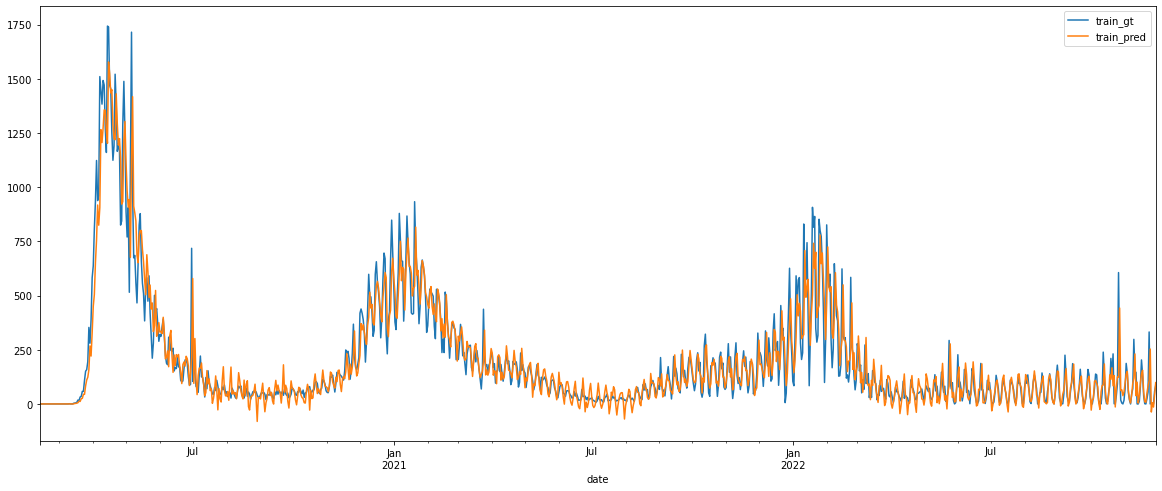

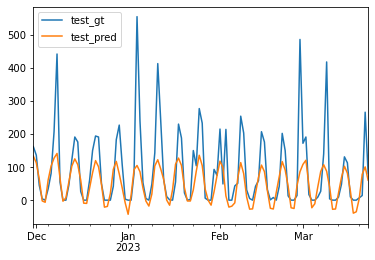

Training Set Metrics:
R-squared: 0.8707452003245586
MAE: 57.22304409019648
MASE: 0.00023820747870331718

Testing Set Metrics:
R-squared: 0.3090746083760957
MAE: 56.467224619028656
MASE: 0.005251906827650216


In [526]:
train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

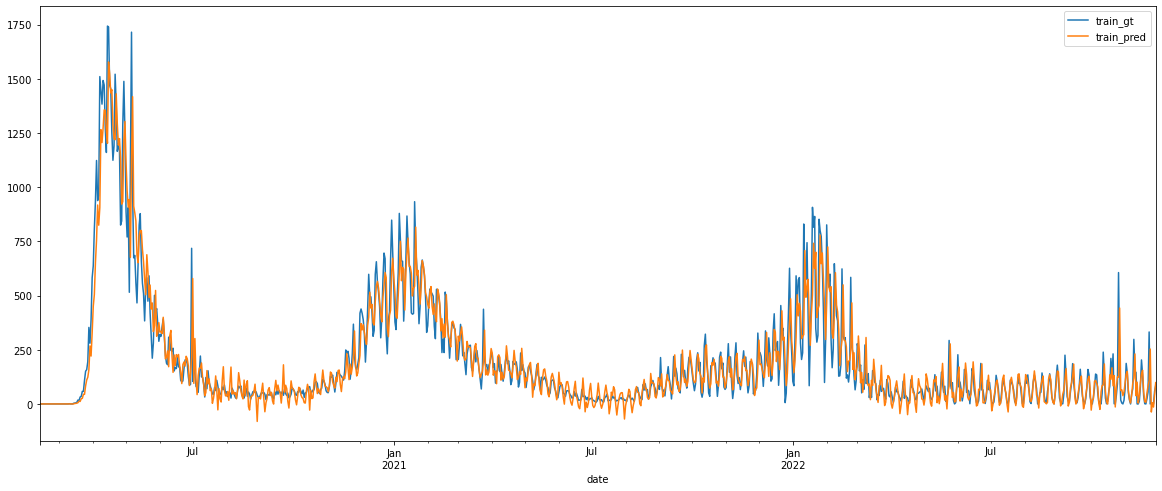

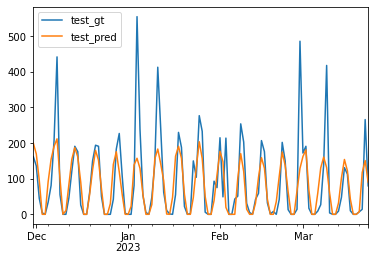

Training Set Metrics:
R-squared: 0.8707452003245586
MAE: 57.22304409019648
MASE: 0.00023820747870331718

Testing Set Metrics:
R-squared: 0.5101745272409257
MAE: 45.038262612373615
MASE: 0.004025366310075676


In [527]:
train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [693]:
model = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=12522.332, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=14336.039, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12503.370, Time=0.72 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=13141.476, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=14779.862, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=12520.988, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=12464.954, Time=5.03 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=12466.925, Time=3.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=12484.035, Time=1.53 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=13635.076, Time=3.33 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=12447.506, Time=5.55 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=12503.829, Time=1.67 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=12449.629, Time=5.17 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=12479.237, Time=2.45 sec
 ARIM

In [690]:
model=auto_arima(east_train,order=(3, 0, 3),seasonal_order=(2,0,2,12))

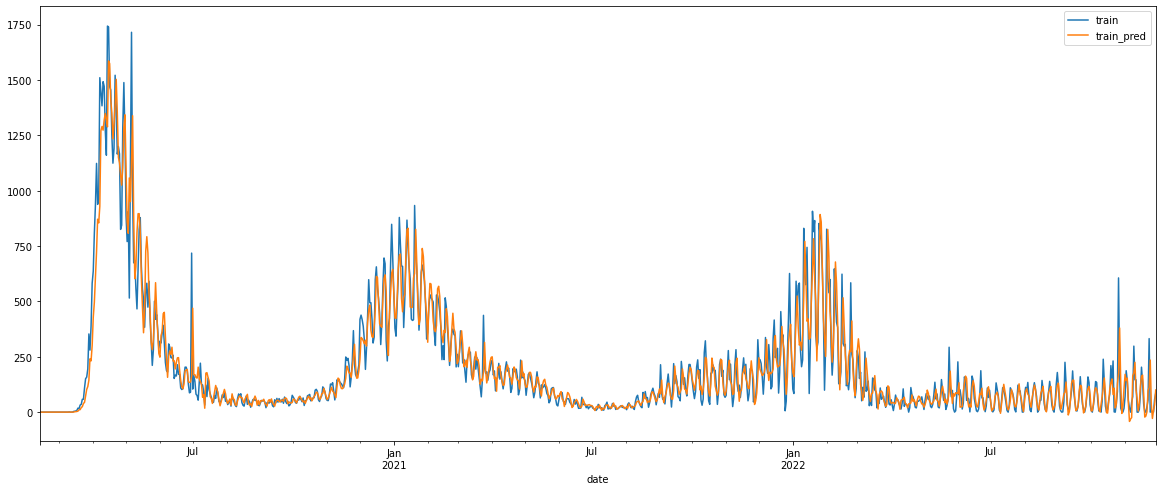

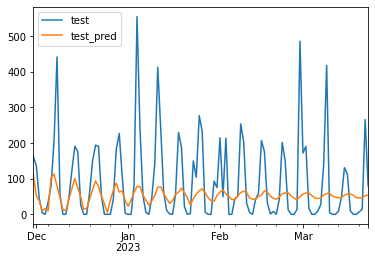

Training Set Metrics:
R-squared: 0.8995634465744584
MAE: 48.442066925165335
MASE: 0.00020378410448084874

Testing Set Metrics:
R-squared: 0.04580490397455095
MAE: 71.86498796297187
MASE: 0.007560539661087029


In [694]:
train_pred=model.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(n_periods=len(east_test))
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

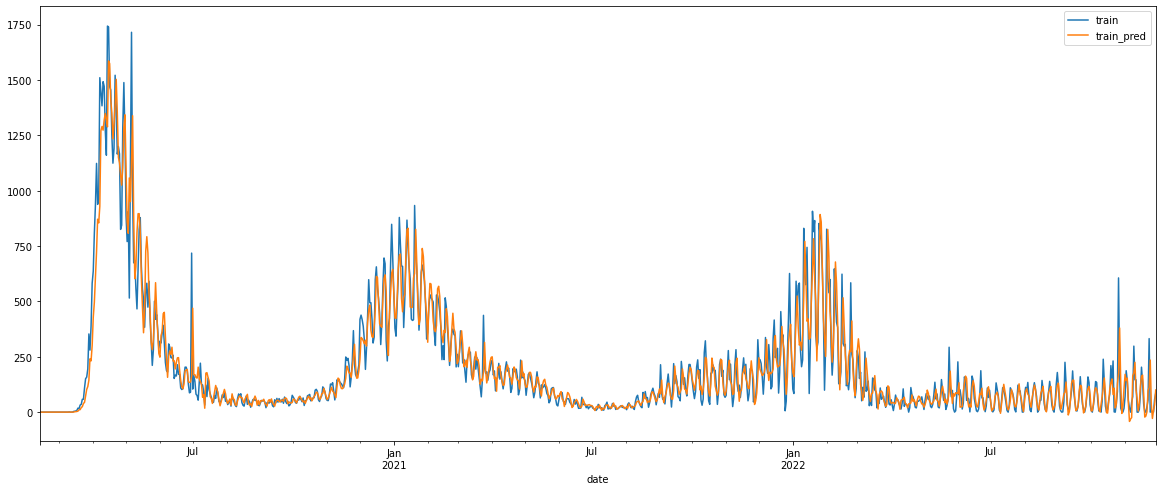

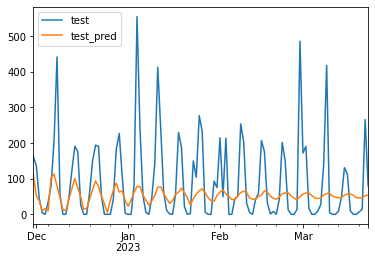

Training Set Metrics:
R-squared: 0.8995634465744584
MAE: 48.442066925165335
MASE: 0.00020378410448084874

Testing Set Metrics:
R-squared: 0.04580490397455095
MAE: 71.86498796297187
MASE: 0.007560539661087029


In [695]:
train_pred=model.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(n_periods=len(east_test))
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [544]:
n_periods=12
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30    157.844979
2022-12-01     79.792493
2022-12-02      2.427338
2022-12-03     16.681382
2022-12-04     35.471193
2022-12-05     29.923421
2022-12-06     85.162328
2022-12-07    139.331229
2022-12-08     86.042106
2022-12-09     13.818449
2022-12-10     21.283209
2022-12-11     37.433696
Freq: D, dtype: float64
Confidence Interval: [[  -0.97024432  316.66020184]
 [ -97.36940988  256.95439543]
 [-181.1813861   186.03606224]
 [-171.08102197  204.4437866 ]
 [-159.62681952  230.56920498]
 [-171.31763522  231.16447646]
 [-131.04201208  301.36666762]
 [-105.62282044  384.28527861]
 [-176.12871896  348.21293016]
 [-252.92238879  280.55928584]
 [-249.2648741   291.83129196]
 [-238.40052648  313.26791865]]


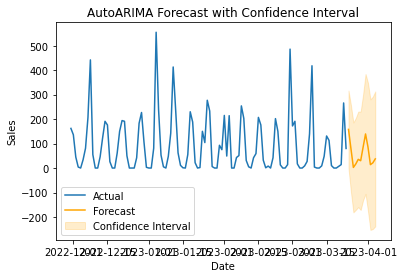

In [545]:
forecast_index = pd.date_range(east_test.index[-1], periods=n_periods + 1, freq=east_test.index.freq)[-n_periods:]

plt.plot(east_test.index, east_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### midwest

In [547]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(midwest_train,order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71893D+00    |proj g|=  1.18806D+00


 This problem is unconstrained.



At iterate    5    f=  7.03387D+00    |proj g|=  2.27606D-02

At iterate   10    f=  7.00919D+00    |proj g|=  7.05795D-03

At iterate   15    f=  7.00050D+00    |proj g|=  3.06631D-02

At iterate   20    f=  6.77353D+00    |proj g|=  7.58734D-02

At iterate   25    f=  6.75765D+00    |proj g|=  5.08491D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   5.085D-06   6.758D+00
  F =   6.7576454942360522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  7.03320D+00    |proj g|=  2.23234D-02

At iterate   10    f=  7.01696D+00    |proj g|=  5.76223D-03

At iterate   15    f=  6.77905D+00    |proj g|=  1.60707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   3.775D-06   6.779D+00
  F =   6.7790481522119554     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71611D+00    |proj g|=  1.18921D+00


 This problem is unconstrained.



At iterate    5    f=  7.02833D+00    |proj g|=  5.96275D-02

At iterate   10    f=  7.00053D+00    |proj g|=  4.93434D-03

At iterate   15    f=  6.99855D+00    |proj g|=  2.58380D-03

At iterate   20    f=  6.83409D+00    |proj g|=  1.00241D-01

At iterate   25    f=  6.73602D+00    |proj g|=  8.44353D-02

At iterate   30    f=  6.72028D+00    |proj g|=  1.20209D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     65      2     0     0   3.465D-05   6.720D+00
  F =   6.7202749860005389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61141D+00    |proj g|=  1.01527D+00


 This problem is unconstrained.



At iterate    5    f=  7.02139D+00    |proj g|=  2.27593D-02

At iterate   10    f=  7.00600D+00    |proj g|=  5.63291D-03

At iterate   15    f=  6.75665D+00    |proj g|=  4.76716D-02

At iterate   20    f=  6.75382D+00    |proj g|=  1.15843D-03

At iterate   25    f=  6.74671D+00    |proj g|=  1.63687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     45      1     0     0   1.014D-05   6.747D+00
  F =   6.7466820014186624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  7.04018D+00    |proj g|=  1.47129D-02

At iterate   10    f=  7.01694D+00    |proj g|=  1.48883D-02

At iterate   15    f=  7.00167D+00    |proj g|=  4.78769D-02

At iterate   20    f=  6.97255D+00    |proj g|=  5.27002D-03

At iterate   25    f=  6.97013D+00    |proj g|=  7.63531D-03

At iterate   30    f=  6.94022D+00    |proj g|=  1.68057D-02

At iterate   35    f=  6.93071D+00    |proj g|=  2.62553D-02

At iterate   40    f=  6.71405D+00    |proj g|=  1.88014D-01

At iterate   45    f=  6.66805D+00    |proj g|=  3.15156D-03

At iterate   50    f=  6.66661D+00    |proj g|=  4.29488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.03565D+00    |proj g|=  1.66635D-02

At iterate   10    f=  7.01562D+00    |proj g|=  6.66473D-02

At iterate   15    f=  6.97302D+00    |proj g|=  5.96432D-03

At iterate   20    f=  6.96222D+00    |proj g|=  9.00797D-03

At iterate   25    f=  6.93503D+00    |proj g|=  8.74461D-02

At iterate   30    f=  6.93494D+00    |proj g|=  4.66894D-02
  ys=-2.454E-09  -gs= 8.934E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35    139      2     1     0   1.999D-01   6.920D+00
  F =   6.9201704662047145     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13971D+00    |proj g|=  1.61166D-01


 This problem is unconstrained.



At iterate    5    f=  7.02577D+00    |proj g|=  3.17916D-02

At iterate   10    f=  6.99302D+00    |proj g|=  4.14202D-02

At iterate   15    f=  6.97363D+00    |proj g|=  7.20241D-03

At iterate   20    f=  6.96976D+00    |proj g|=  5.31724D-03

At iterate   25    f=  6.95006D+00    |proj g|=  4.28495D-02

At iterate   30    f=  6.88310D+00    |proj g|=  8.35709D-02

At iterate   35    f=  6.73476D+00    |proj g|=  9.40336D-02

At iterate   40    f=  6.60916D+00    |proj g|=  1.47492D-01

At iterate   45    f=  6.58583D+00    |proj g|=  3.00114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     76   

 This problem is unconstrained.



At iterate    5    f=  7.02572D+00    |proj g|=  1.70627D-02

At iterate   10    f=  7.00759D+00    |proj g|=  4.31295D-02

At iterate   15    f=  6.96728D+00    |proj g|=  7.99848D-03

At iterate   20    f=  6.96466D+00    |proj g|=  3.10453D-03

At iterate   25    f=  6.89044D+00    |proj g|=  6.97323D-03

At iterate   30    f=  6.85743D+00    |proj g|=  1.28112D-02

At iterate   35    f=  6.84573D+00    |proj g|=  9.19073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     99      1     0     0   1.538D-02   6.846D+00
  F =   6.8457334924718021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18496D+00    |proj g|=  2.84479D-01


 This problem is unconstrained.



At iterate    5    f=  7.00571D+00    |proj g|=  4.60547D-02

At iterate   10    f=  6.98005D+00    |proj g|=  9.84086D-03

At iterate   15    f=  6.97768D+00    |proj g|=  2.99809D-02

At iterate   20    f=  6.75318D+00    |proj g|=  2.11441D-02

At iterate   25    f=  6.75196D+00    |proj g|=  4.61996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     41      1     0     0   3.155D-05   6.752D+00
  F =   6.7519633347532055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  6.99046D+00    |proj g|=  1.86597D-02

At iterate   10    f=  6.97865D+00    |proj g|=  4.16286D-03

At iterate   15    f=  6.96296D+00    |proj g|=  2.64120D-02

At iterate   20    f=  6.76811D+00    |proj g|=  7.88181D-02

At iterate   25    f=  6.76154D+00    |proj g|=  7.73015D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     32      1     0     0   3.836D-05   6.762D+00
  F =   6.7615400311257003     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  6.99476D+00    |proj g|=  3.38779D-02

At iterate   10    f=  6.96419D+00    |proj g|=  6.46529D-03

At iterate   15    f=  6.96270D+00    |proj g|=  2.79415D-03

At iterate   20    f=  6.95236D+00    |proj g|=  1.88011D-01

At iterate   25    f=  6.74359D+00    |proj g|=  8.68370D-02

At iterate   30    f=  6.69088D+00    |proj g|=  8.89376D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     39      1     0     0   2.639D-06   6.691D+00
  F =   6.6908172551566238     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.98292D+00    |proj g|=  1.53752D-02

At iterate   10    f=  6.97010D+00    |proj g|=  1.20118D-02

At iterate   15    f=  6.96022D+00    |proj g|=  1.80127D-03

At iterate   20    f=  6.95896D+00    |proj g|=  1.53618D-02

At iterate   25    f=  6.88529D+00    |proj g|=  1.65714D-01

At iterate   30    f=  6.84051D+00    |proj g|=  3.45844D-02

At iterate   35    f=  6.80611D+00    |proj g|=  2.11429D-01

At iterate   40    f=  6.69669D+00    |proj g|=  3.90092D-02

At iterate   45    f=  6.69295D+00    |proj g|=  2.03714D-02

At iterate   50    f=  6.69086D+00    |proj g|=  5.35399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.99669D+00    |proj g|=  2.46063D-02

At iterate   10    f=  6.98122D+00    |proj g|=  9.92227D-03

At iterate   15    f=  6.97771D+00    |proj g|=  2.14775D-03

At iterate   20    f=  5.43464D-01    |proj g|=  9.00207D+05
  ys=-1.974E+09  -gs= 8.165E+00 BFGS update SKIPPED


LinAlgError: LU decomposition error.

In [548]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

,p,q,P,Q,aic
6,1,2,2,1,13475.416805
4,1,2,1,1,13638.544255
10,2,1,2,1,13690.030470
11,2,1,2,2,13692.111494
2,1,1,2,1,13748.242071
3,1,1,2,2,13804.218011
8,2,1,1,1,13813.013056
0,1,1,1,1,13822.627390
9,2,1,1,2,13834.587824
1,1,1,1,2,13868.374423


In [549]:
model=sm.tsa.statespace.SARIMAX(midwest_train,order=(1, 1, 2),seasonal_order=(2,1,1,12))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13971D+00    |proj g|=  1.61166D-01

At iterate    5    f=  7.02577D+00    |proj g|=  3.17916D-02

At iterate   10    f=  6.99302D+00    |proj g|=  4.14202D-02

At iterate   15    f=  6.97363D+00    |proj g|=  7.20241D-03

At iterate   20    f=  6.96976D+00    |proj g|=  5.31724D-03

At iterate   25    f=  6.95006D+00    |proj g|=  4.28495D-02

At iterate   30    f=  6.88310D+00    |proj g|=  8.35709D-02

At iterate   35    f=  6.73476D+00    |proj g|=  9.40336D-02

At iterate   40    f=  6.60916D+00    |proj g|=  1.47492D-01

At iterate   45    f=  6.58583D+00    |proj g|=  3.00114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

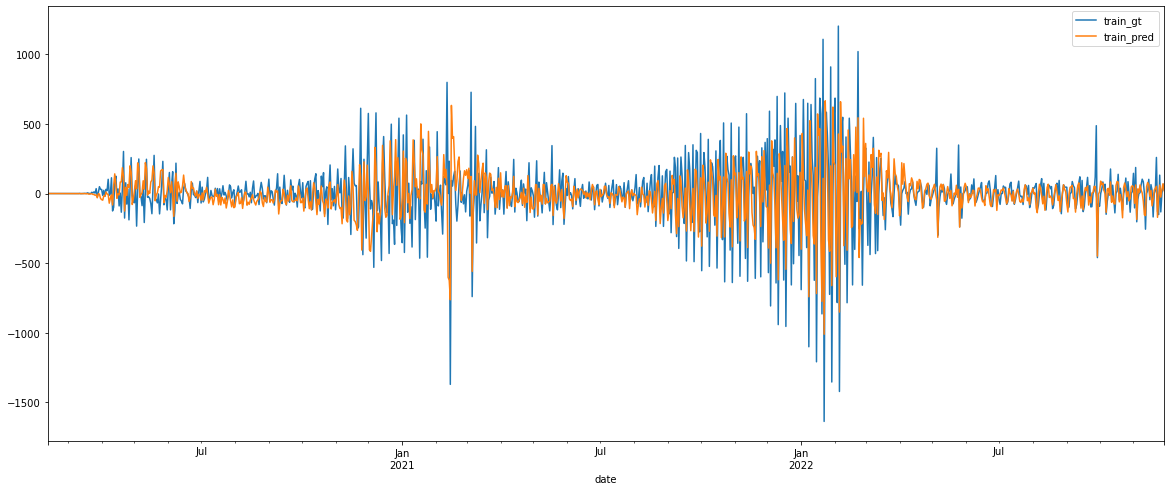

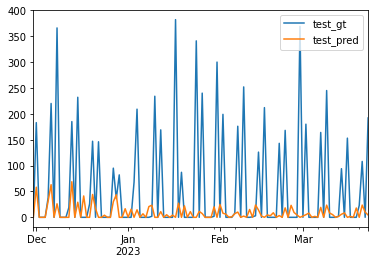

Training Set Metrics:
R-squared: 0.3980433644187892
MAE: 119.76284876714325
MASE: 0.0006111066461935677

Testing Set Metrics:
R-squared: -0.20211173436740393
MAE: 56.941721196739444
MASE: 0.008396512630337733


In [554]:
train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [555]:
model = auto_arima(midwest_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15553.452, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14927.211, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15348.416, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=14796.238, Time=1.46 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.87 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=15340.365, Time=0.66 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=14659.558, Time=3.58 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=14855.256, Time=1.55 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=13.41 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.00 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=14435.877, Time=8.61 sec
 ARIMA(3,1,0)(1,1,0)[12]             : A

In [574]:
model=auto_arima(midwest_train,order=(3, 1, 0),seasonal_order=(2,1,0,12))

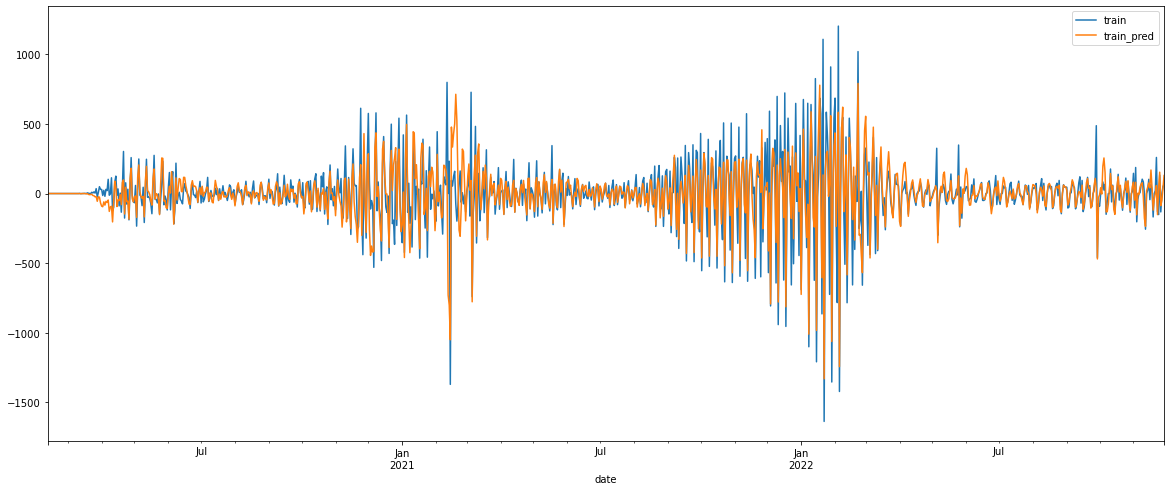

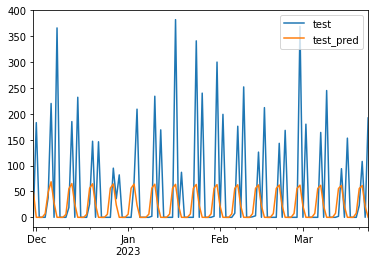

Training Set Metrics:
R-squared: 0.6167593755567007
MAE: 83.95055974987929
MASE: 0.0004044028317976503

Testing Set Metrics:
R-squared: -0.07679082109152557
MAE: 58.60929564531627
MASE: 0.007999882223278385


In [580]:
train_pred=model.fittedvalues()
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(n_periods=len(midwest_test))
test_pred[test_pred<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [581]:
n_periods=12
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30    49.903799
2022-12-01     0.000000
2022-12-02     0.000000
2022-12-03     0.000000
2022-12-04     7.075075
2022-12-05    48.256980
2022-12-06    68.703862
2022-12-07    27.751771
2022-12-08     0.000000
2022-12-09     0.000000
2022-12-10     0.000000
2022-12-11     5.625119
Freq: D, dtype: float64
Confidence Interval: [[-240.73555275  340.54315002]
 [-470.6865937   357.94387543]
 [-483.52633473  348.15902179]
 [-458.49900668  373.44849797]
 [-408.91950343  423.06965321]
 [-371.36901295  467.88297225]
 [-363.04975011  500.45747383]
 [-406.21996522  461.72350814]
 [-472.14285301  398.72011474]
 [-508.34699847  369.21134613]
 [-486.52135547  391.55445663]
 [-433.67259164  444.92283017]]


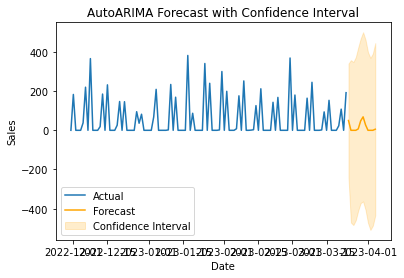

In [582]:
forecast_index = pd.date_range(midwest_test.index[-1], periods=n_periods + 1, freq=midwest_test.index.freq)[-n_periods:]

plt.plot(midwest_test.index, midwest_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### south

In [570]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(south_train,order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52551D+00    |proj g|=  1.11867D-01


 This problem is unconstrained.



At iterate    5    f=  7.41953D+00    |proj g|=  9.68178D-03

At iterate   10    f=  7.41339D+00    |proj g|=  1.14831D-03

At iterate   15    f=  7.24227D+00    |proj g|=  3.27073D-01

At iterate   20    f=  7.12400D+00    |proj g|=  6.72196D-03

At iterate   25    f=  7.12240D+00    |proj g|=  1.59225D-03

At iterate   30    f=  7.12229D+00    |proj g|=  3.98782D-04

At iterate   35    f=  7.12228D+00    |proj g|=  1.61276D-04

At iterate   40    f=  7.12228D+00    |proj g|=  5.52916D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     55      1     0     0   5.529D-05   7.122D+00
  F =   7.12228039481

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46987D+00    |proj g|=  1.12717D-01

At iterate    5    f=  7.42471D+00    |proj g|=  4.80938D-03

At iterate   10    f=  7.41163D+00    |proj g|=  1.05080D-02

At iterate   15    f=  7.40660D+00    |proj g|=  1.16643D-03

At iterate   20    f=  7.39486D+00    |proj g|=  5.61247D-02

At iterate   25    f=  7.12188D+00    |proj g|=  6.01010D-02

At iterate   30    f=  7.10459D+00    |proj g|=  8.24223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.50503D+00    |proj g|=  1.33566D-01


 This problem is unconstrained.



At iterate    5    f=  7.41950D+00    |proj g|=  2.19011D-02

At iterate   10    f=  7.40779D+00    |proj g|=  2.18203D-03

At iterate   15    f=  7.40370D+00    |proj g|=  4.29185D-03

At iterate   20    f=  7.29728D+00    |proj g|=  1.98599D-01

At iterate   25    f=  7.09437D+00    |proj g|=  1.89202D-02

At iterate   30    f=  7.08944D+00    |proj g|=  3.06124D-03

At iterate   35    f=  7.08901D+00    |proj g|=  4.21709D-04

At iterate   40    f=  7.08897D+00    |proj g|=  1.47257D-03

At iterate   45    f=  7.08896D+00    |proj g|=  1.20010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     65   

 This problem is unconstrained.



At iterate    5    f=  7.41565D+00    |proj g|=  5.05097D-03

At iterate   10    f=  7.41113D+00    |proj g|=  7.24797D-03

At iterate   15    f=  7.40395D+00    |proj g|=  1.20680D-03

At iterate   20    f=  7.40258D+00    |proj g|=  1.19366D-02
  ys=-1.322E-01  -gs= 7.573E-02 BFGS update SKIPPED
  ys=-2.373E+00  -gs= 1.074E-01 BFGS update SKIPPED

At iterate   25    f=  4.42865D-02    |proj g|=  8.35392D+02
  ys=-2.528E-01  -gs= 7.059E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29    133      2     3     0   2.808D+03   4.303D-02
  F =   4.3030369664800908E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49230D+00    |proj g|=  7.08792D-02


 This problem is unconstrained.



At iterate    5    f=  7.37209D+00    |proj g|=  2.00291D-03

At iterate   10    f=  7.15250D+00    |proj g|=  9.37576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     23      1     0     0   3.556D-05   7.142D+00
  F =   7.1415262228886496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.43555D+00    |proj g|=  6.79596D-02


 This problem is unconstrained.



At iterate    5    f=  7.37863D+00    |proj g|=  2.89568D-03

At iterate   10    f=  7.37285D+00    |proj g|=  6.22186D-03

At iterate   15    f=  7.36420D+00    |proj g|=  1.15932D-03

At iterate   20    f=  7.16896D+00    |proj g|=  8.25143D-01

At iterate   25    f=  7.16777D+00    |proj g|=  3.75142D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25    120      1     0     0   3.751D-01   7.168D+00
  F =   7.1677660853715626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46764D+00    |proj g|=  6.13361D-02


 This problem is unconstrained.



At iterate    5    f=  7.37194D+00    |proj g|=  1.23996D-02

At iterate   10    f=  7.36711D+00    |proj g|=  1.49161D-03

At iterate   15    f=  7.16219D+00    |proj g|=  2.79532D-01

At iterate   20    f=  7.13197D+00    |proj g|=  9.59579D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     26      1     0     0   9.596D-06   7.132D+00
  F =   7.1319723782312332     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  7.37246D+00    |proj g|=  5.62188D-03

At iterate   10    f=  7.36963D+00    |proj g|=  2.39501D-03

At iterate   15    f=  7.35538D+00    |proj g|=  2.24112D-02
  ys=-6.578E+00  -gs= 1.864E-01 BFGS update SKIPPED

At iterate   20    f= -0.00000D+00    |proj g|=  1.12240D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     75      2     1     0   1.122D+03  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56710D+00    |proj g|=  1.04209D-01


 This problem is unconstrained.



At iterate    5    f=  7.38889D+00    |proj g|=  3.93449D-02

At iterate   10    f=  7.38214D+00    |proj g|=  4.47431D-03

At iterate   15    f=  7.36292D+00    |proj g|=  2.61221D-02

At iterate   20    f=  7.12037D+00    |proj g|=  8.62531D-02

At iterate   25    f=  7.10953D+00    |proj g|=  1.61152D-02

At iterate   30    f=  7.10799D+00    |proj g|=  5.79954D-04

At iterate   35    f=  7.10790D+00    |proj g|=  1.53462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     47      1     0     0   2.553D-04   7.108D+00
  F =   7.1078881494080912     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.39757D+00    |proj g|=  1.46744D-02

At iterate   10    f=  7.38716D+00    |proj g|=  3.11223D-03

At iterate   15    f=  7.38266D+00    |proj g|=  2.36577D-02

At iterate   20    f=  7.29982D+00    |proj g|=  8.54900D-02

At iterate   25    f=  7.12241D+00    |proj g|=  2.48578D-02

At iterate   30    f=  7.12179D+00    |proj g|=  4.45965D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     65      1     0     0   4.885D-05   7.122D+00
  F =   7.1217919354213199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52658D+00    |proj g|=  1.04068D-01


 This problem is unconstrained.



At iterate    5    f=  7.38733D+00    |proj g|=  3.63778D-02

At iterate   10    f=  7.37022D+00    |proj g|=  1.40960D-02

At iterate   15    f=  7.36874D+00    |proj g|=  1.36947D-03

At iterate   20    f=  7.36213D+00    |proj g|=  1.53111D-02

At iterate   25    f=  7.22623D+00    |proj g|=  8.67282D-02

At iterate   30    f=  7.08797D+00    |proj g|=  1.43037D-01

At iterate   35    f=  7.05621D+00    |proj g|=  8.50224D-03

At iterate   40    f=  7.05516D+00    |proj g|=  1.13186D-02

At iterate   45    f=  7.05457D+00    |proj g|=  3.13052D-03

At iterate   50    f=  7.05454D+00    |proj g|=  7.21891D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.39459D+00    |proj g|=  1.98690D-02

At iterate   10    f=  7.37699D+00    |proj g|=  1.49015D-02

At iterate   15    f=  7.36750D+00    |proj g|=  1.34124D-03

At iterate   20    f=  7.36696D+00    |proj g|=  1.93132D-03

At iterate   25    f=  7.36106D+00    |proj g|=  2.60610D-02

At iterate   30    f=  7.21387D+00    |proj g|=  1.42331D-01

At iterate   35    f=  7.19189D+00    |proj g|=  2.62831D-02

At iterate   40    f=  7.07169D+00    |proj g|=  6.34877D-02

At iterate   45    f=  7.05443D+00    |proj g|=  2.24067D-02

At iterate   50    f=  7.05405D+00    |proj g|=  1.18281D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.36228D+00    |proj g|=  9.94728D-03

At iterate   10    f=  7.36063D+00    |proj g|=  1.16620D-03

At iterate   15    f=  7.34518D+00    |proj g|=  1.38647D-01

At iterate   20    f=  7.26222D+00    |proj g|=  1.12937D-01

At iterate   25    f=  7.24430D+00    |proj g|=  7.04155D-02

At iterate   30    f=  7.24034D+00    |proj g|=  2.09985D-02
  ys=-1.732E-03  -gs= 4.758E-03 BFGS update SKIPPED

At iterate   35    f=  7.23965D+00    |proj g|=  3.02305D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  7.23923D+00    |proj g|=  4.10641D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.402E-09  -gs= 7.838E-10 BFGS update SKIPPED

At iterate   45    f=  7.23922D+00    |proj g|=  5.08617D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46    271      7     2     0   5.086D-02   7.239D+00
  F =   7.2392191165123956     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.43616D+00    |proj g|=  9.75197D-02


 This problem is unconstrained.



At iterate    5    f=  7.36900D+00    |proj g|=  4.29261D-03

At iterate   10    f=  7.36702D+00    |proj g|=  2.42010D-03

At iterate   15    f=  7.35701D+00    |proj g|=  7.40320D-03

At iterate   20    f=  7.35119D+00    |proj g|=  4.06211D-03
  ys=-9.231E+00  -gs= 3.082E-02 BFGS update SKIPPED


LinAlgError: LU decomposition error.

In [571]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

,p,q,P,Q,aic
7,1,2,2,2,16.000000
3,1,1,2,2,101.954076
10,2,1,2,1,14433.475313
11,2,1,2,2,14434.486385
2,1,1,2,1,14501.825864
1,1,1,1,2,14533.787794
8,2,1,1,1,14540.523377
0,1,1,1,1,14567.941127
9,2,1,1,2,14570.942716
6,1,2,2,1,14591.751541


ACF tails off and PACF cutoff at lag 2 -> AR(2) model

In [600]:
model=sm.tsa.statespace.SARIMAX(south_train,order=(2, 1, 1),seasonal_order=(2,1,1,12))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52658D+00    |proj g|=  1.04068D-01

At iterate    5    f=  7.38733D+00    |proj g|=  3.63778D-02

At iterate   10    f=  7.37022D+00    |proj g|=  1.40960D-02

At iterate   15    f=  7.36874D+00    |proj g|=  1.36947D-03

At iterate   20    f=  7.36213D+00    |proj g|=  1.53111D-02

At iterate   25    f=  7.22623D+00    |proj g|=  8.67282D-02

At iterate   30    f=  7.08797D+00    |proj g|=  1.43037D-01

At iterate   35    f=  7.05621D+00    |proj g|=  8.50224D-03

At iterate   40    f=  7.05516D+00    |proj g|=  1.13186D-02

At iterate   45    f=  7.05457D+00    |proj g|=  3.13052D-03

At iterate   50    f=  7.05454D+00    |proj g|=  7.21891D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

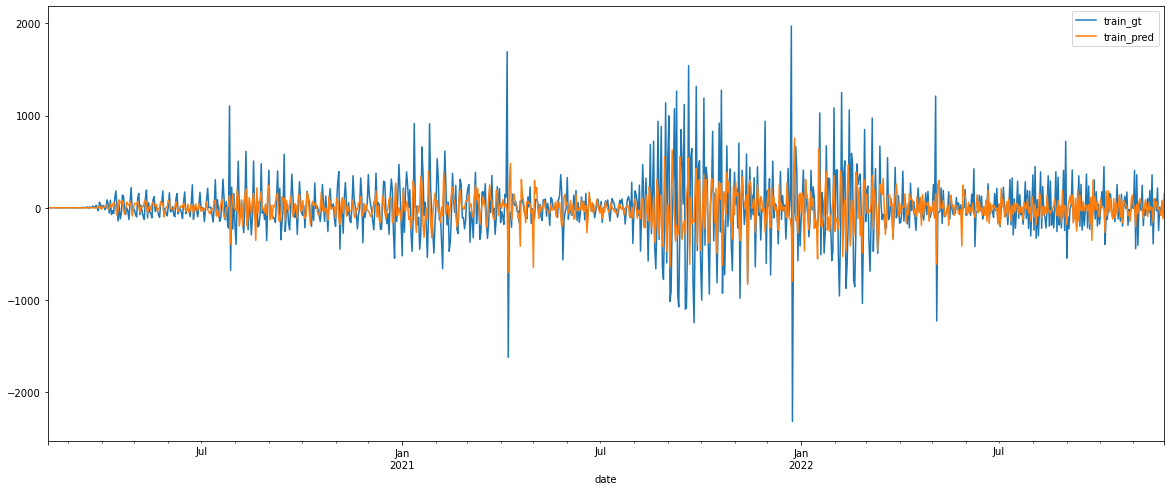

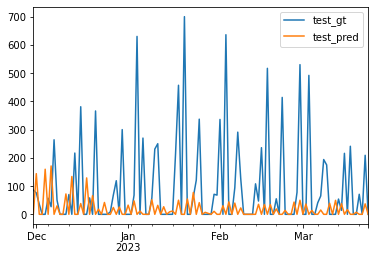

Training Set Metrics:
R-squared: 0.19428316019585823
MAE: 192.800618683672
MASE: 0.0007622988326362485

Testing Set Metrics:
R-squared: -0.3335776419291503
MAE: 102.24925460134261
MASE: 0.009038094158031319


In [606]:
train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(south_train, train_pred)
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(south_test, test_pred)
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

### west

In [607]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(west_train,order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78629D+00    |proj g|=  1.61520D-01

At iterate    5    f=  6.66157D+00    |proj g|=  4.28275D-02

At iterate   10    f=  6.65058D+00    |proj g|=  2.41326D-03

At iterate   15    f=  6.40347D+00    |proj g|=  6.73648D-02

At iterate   20    f=  6.40032D+00    |proj g|=  6.66960D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     27      1     0     0   6.670D-06   6.400D+00
  F =   6.4003206984830987     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71793D+00    |proj g|=  1.47446D-01

At iterate    5    f=  6.65958D+00    |proj g|=  6.57630D-03

At iterate   10    f=  6.64013D+00    |proj g|=  4.75743D-03

At iterate   15    f=  6.41204D+00    |proj g|=  6.69221D-04

At iterate   20    f=  6.41201D+00    |proj g|=  2.76941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     37      1     0     0   2.865D-03   6.412D+00
  F =   6.4119996256198677     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  6.65020D+00    |proj g|=  2.82178D-02

At iterate   10    f=  6.63815D+00    |proj g|=  4.02141D-03

At iterate   15    f=  6.63327D+00    |proj g|=  4.18413D-03

At iterate   20    f=  6.35760D+00    |proj g|=  1.62094D-01

At iterate   25    f=  6.34363D+00    |proj g|=  6.41027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   6.394D-05   6.344D+00
  F =   6.3436317482815712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.73392D+00    |proj g|=  1.81334D-01

At iterate    5    f=  6.64878D+00    |proj g|=  7.36955D-03

At iterate   10    f=  6.63510D+00    |proj g|=  5.82456D-03

At iterate   15    f=  6.63383D+00    |proj g|=  1.24092D-02

At iterate   20    f=  6.59897D+00    |proj g|=  1.52776D-01

At iterate   25    f=  6.41703D+00    |proj g|=  4.48469D-02

At iterate   30    f=  6.40371D+00    |proj g|=  1.27747D-02

At iterate   35    f=  6.39671D+00    |proj g|=  4.07144D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03310D+00    |proj g|=  6.36653D-01


 This problem is unconstrained.



At iterate    5    f=  6.60428D+00    |proj g|=  3.71367D-02

At iterate   10    f=  6.58049D+00    |proj g|=  2.46674D-03

At iterate   15    f=  6.53896D+00    |proj g|=  5.15984D-02
  ys=-1.396E+00  -gs= 1.612E-01 BFGS update SKIPPED
  ys=-9.781E+08  -gs= 2.501E+01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     76      2     2     0   3.073D+05   4.724D+00
  F =   4.7237803905582396     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89651D+00    |proj g|=  5.30764D-01

At iterate    5    f=  6.59125D+00    |proj g|=  1.61952D-02

At iterate   10    f=  6.58156D+00    |proj g|=  2.36063D-03

At iterate   15    f=  6.56912D+00    |proj g|=  1.13533D-02

At iterate   20    f=  6.42558D+00    |proj g|=  1.08340D-05
  ys=-1.375E-04  -gs= 1.069E-04 BFGS update SKIPPED

At iterate   25    f=  6.42485D+00    |proj g|=  8.33227D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.



At iterate    5    f=  6.59429D+00    |proj g|=  4.40084D-02

At iterate   10    f=  6.57104D+00    |proj g|=  1.46485D-02

At iterate   15    f=  6.54114D+00    |proj g|=  7.68847D-02

At iterate   20    f=  6.50952D+00    |proj g|=  1.74975D-02

At iterate   25    f=  6.50735D+00    |proj g|=  2.03670D-02

At iterate   30    f=  6.50061D+00    |proj g|=  1.83442D-02

At iterate   35    f=  6.49373D+00    |proj g|=  2.23657D-02

At iterate   40    f=  6.30617D+00    |proj g|=  1.15500D-01

At iterate   45    f=  6.25427D+00    |proj g|=  2.62968D-02

At iterate   50    f=  6.25347D+00    |proj g|=  9.31663D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95087D+00    |proj g|=  6.38694D-01

At iterate    5    f=  6.58558D+00    |proj g|=  2.06533D-02

At iterate   10    f=  6.57496D+00    |proj g|=  6.17033D-03

At iterate   15    f=  6.52049D+00    |proj g|=  1.41927D-02

At iterate   20    f=  6.50897D+00    |proj g|=  5.07905D-03

At iterate   25    f=  6.48342D+00    |proj g|=  1.28796D-01

At iterate   30    f=  6.30399D+00    |proj g|=  2.69738D-02

At iterate   35    f=  6.27474D+00    |proj g|=  1.47691D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  6.27436D+00    |proj g|=  7.86561D-04

At iterate   45    f=  6.27436D+00    |proj g|=  4.48351D-04

At iterate   50    f=  6.27335D+00    |proj g|=  1.67885D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     80      2     0     0   1.679D-02   6.273D+00
  F =   6.2733463502833775     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81963D+00    |proj g|=  1.20461D-01


 This problem is unconstrained.



At iterate    5    f=  6.65307D+00    |proj g|=  1.25422D-02

At iterate   10    f=  6.63918D+00    |proj g|=  2.42821D-03

At iterate   15    f=  6.42003D+00    |proj g|=  1.58361D-01

At iterate   20    f=  6.39447D+00    |proj g|=  2.14091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     30      1     0     0   9.668D-06   6.394D+00
  F =   6.3944695075884743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.64753D+00    |proj g|=  1.31103D-02

At iterate   10    f=  6.63450D+00    |proj g|=  2.20623D-02

At iterate   15    f=  6.47018D+00    |proj g|=  1.93612D-01

At iterate   20    f=  6.40025D+00    |proj g|=  2.15769D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     29      1     0     0   1.870D-05   6.400D+00
  F =   6.4002455819111406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78352D+00    |proj g|=  1.88020D-01

At iterate    5    f=  6.63820D+00    |proj g|=  3.68358D-02

At iterate   10    f=  6.62053D+00    |proj g|=  1.06390D-02

At iterate   15    f=  6.61770D+00    |proj g|=  7.08847D-03

At iterate   20    f=  6.49764D+00    |proj g|=  1.63702D-01

At iterate   25    f=  6.38118D+00    |proj g|=  8.41980D-02

At iterate   30    f=  6.31470D+00    |proj g|=  6.88390D-02

At iterate   35    f=  6.31162D+00    |proj g|=  5.27408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  6.63440D+00    |proj g|=  4.41925D-02

At iterate   10    f=  6.61829D+00    |proj g|=  2.59138D-03

At iterate   15    f=  6.61664D+00    |proj g|=  6.42881D-03

At iterate   20    f=  6.56629D+00    |proj g|=  1.97186D-01

At iterate   25    f=  6.39612D+00    |proj g|=  2.65008D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     49      1     0     0   2.625D-02   6.396D+00
  F =   6.3961234114984800     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04381D+00    |proj g|=  6.72996D-01


 This problem is unconstrained.



At iterate    5    f=  6.57968D+00    |proj g|=  3.34794D-02

At iterate   10    f=  6.55339D+00    |proj g|=  1.83203D-02

At iterate   15    f=  6.55047D+00    |proj g|=  5.58744D-03

At iterate   20    f=  6.40185D+00    |proj g|=  3.90754D-02

At iterate   25    f=  6.40024D+00    |proj g|=  1.25544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     31      1     0     0   1.255D-05   6.400D+00
  F =   6.4002438225252991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89927D+00    |proj g|=  5.61062D-01

At iterate    5    f=  6.56792D+00    |proj g|=  2.36109D-02

At iterate   10    f=  6.55521D+00    |proj g|=  2.41514D-03

At iterate   15    f=  6.53852D+00    |proj g|=  4.30758D-02

At iterate   20    f=  6.41241D+00    |proj g|=  7.79783D-04

At iterate   25    f=  6.41193D+00    |proj g|=  5.30224D-05
  ys=-5.116E-03  -gs= 1.932E-04 BFGS update SKIPPED

At iterate   30    f=  6.40935D+00    |proj g|=  2.02281D-02

At iterate   35    f=  6.40863D+00    |proj g|=  4.32340D-04

At iterate   40    f=  6.40800D+00    |proj g|=  1.04188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.



At iterate    5    f=  6.54999D+00    |proj g|=  3.18975D-02

At iterate   10    f=  6.52839D+00    |proj g|=  7.22210D-03

At iterate   15    f=  6.52343D+00    |proj g|=  1.47096D-02

At iterate   20    f=  6.35475D+00    |proj g|=  1.61827D-01

At iterate   25    f=  6.34225D+00    |proj g|=  1.27846D-03

At iterate   30    f=  6.34214D+00    |proj g|=  6.16732D-03

At iterate   35    f=  6.34206D+00    |proj g|=  4.80156D-04

At iterate   40    f=  6.34098D+00    |proj g|=  2.57967D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


LinAlgError: LU decomposition error.

In [608]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

,p,q,P,Q,aic
4,1,2,1,1,9667.407118
6,1,2,2,1,12796.087474
7,1,2,2,2,12838.719940
10,2,1,2,1,12914.954224
2,1,1,2,1,12978.383293
8,2,1,1,1,13082.295674
3,1,1,2,2,13085.569743
11,2,1,2,2,13089.676253
0,1,1,1,1,13092.255508
12,2,2,1,1,13096.098373


In [614]:
model=sm.tsa.statespace.SARIMAX(west_train,order=(1, 1, 2),seasonal_order=(1,1,1,12))
model=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03310D+00    |proj g|=  6.36653D-01


 This problem is unconstrained.



At iterate    5    f=  6.60428D+00    |proj g|=  3.71367D-02

At iterate   10    f=  6.58049D+00    |proj g|=  2.46674D-03

At iterate   15    f=  6.53896D+00    |proj g|=  5.15984D-02
  ys=-1.396E+00  -gs= 1.612E-01 BFGS update SKIPPED
  ys=-9.781E+08  -gs= 2.501E+01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     76      2     2     0   3.073D+05   4.724D+00
  F =   4.7237803905582396     

ABNORMAL_TERMINATION_IN_LNSRCH                              


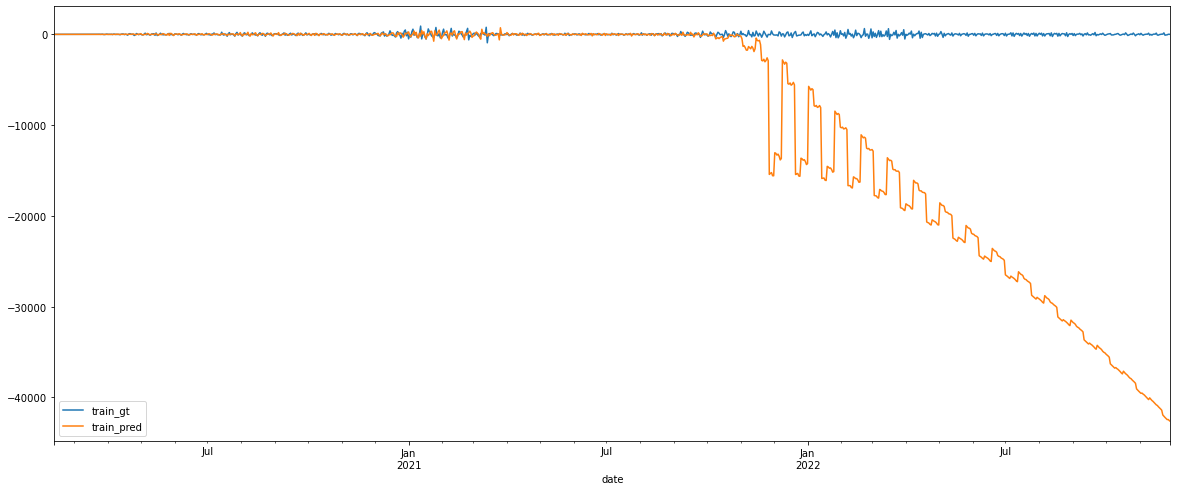

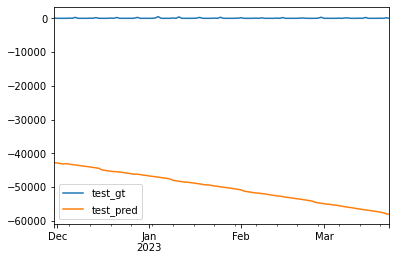

Training Set Metrics:
R-squared: -9621.890055313954
MAE: 8605.959928820661
MASE: 0.0009762055587046463

Testing Set Metrics:
R-squared: -290793.5617984754
MAE: 50201.26002787222
MASE: 0.00883799146004505


In [615]:
train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
#test_pred[test_pred<0] = 0
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [616]:
model = auto_arima(west_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14624.753, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14132.681, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14472.144, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13939.576, Time=1.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.86 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=14295.175, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=13814.483, Time=2.20 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=14096.545, Time=1.09 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.47 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.15 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=13630.779, Time=4.10 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

In [674]:
model=auto_arima(west_train,order=(3, 1, 0),seasonal_order=(2,1,0,12))

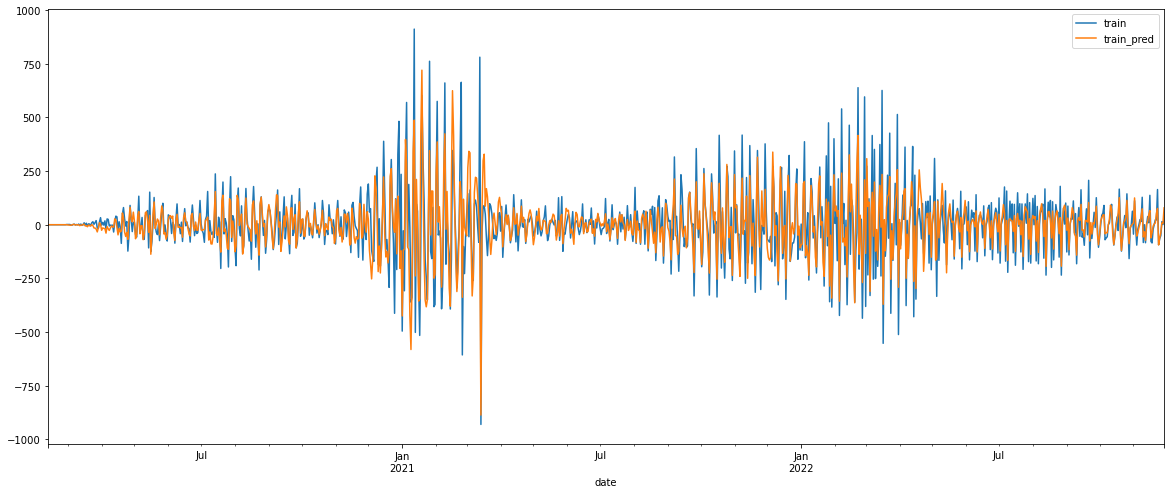

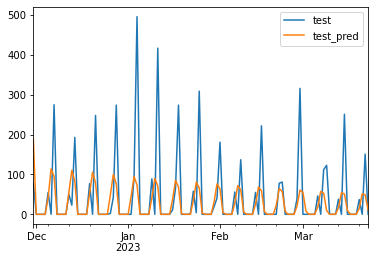

Training Set Metrics:
R-squared: 0.5990097421493225
MAE: 63.67878089959083
MASE: 0.0004445422936639363

Testing Set Metrics:
R-squared: 0.2086993765588001
MAE: 39.70083865788431
MASE: 0.006174134626446577


In [675]:
train_pred=model.fittedvalues()
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(n_periods=len(west_test))
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)